In [1]:
#=======================================
## Tree-like neural network - Iris
#=======================================

#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, concatenate, Dropout


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#----------------------------------------
# Load the iris dataset.

dataset = np.loadtxt("IRIS-Training-Data.txt")

print(type(dataset))

print(dataset.shape)

x_group = [[2], [3]]

X = dataset[:, 0:4]
Y = dataset[:, 4]

print(X.shape)
print(Y.shape)

X1 = dataset[:, x_group[0]]
X2 = dataset[:, x_group[1]]

print(X1.shape)
print(X2.shape)
print(Y.shape)

Y = np.array(Y, dtype = int)

print(np.unique(Y))


<class 'numpy.ndarray'>
(150, 5)
(150, 4)
(150,)
(150, 1)
(150, 1)
(150,)
[1 2 3]


In [3]:
#----------------------------------------
# one-hot encoding of output variable.

Y_train = np.zeros((len(Y), 3), dtype = int)

for i in range(len(Y)):
	Y_train[i, Y[i] - 1] = 1

print(np.unique(Y_train))


[0 1]


In [4]:
#----------------------------------------
# Standardize the input and output data.

X_sample_mean = np.mean(X, axis = 0)
print(np.round(X_sample_mean, 4))

X_sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(X_sample_std, 4))

X1_sample_mean = X_sample_mean[x_group[0]]
print(np.round(X1_sample_mean, 4))

X1_sample_std = X_sample_std[x_group[0]]
print(np.round(X1_sample_std, 4))

X2_sample_mean = X_sample_mean[x_group[1]]
print(np.round(X2_sample_mean, 4))

X2_sample_std = X_sample_std[x_group[1]]
print(np.round(X2_sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

X1_train = X_train[:, x_group[0]]
X2_train = X_train[:, x_group[1]]

print(np.round(np.mean(X1_train, axis = 0), 4))
print(np.round(np.std(X1_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X2_train, axis = 0), 4))
print(np.round(np.std(X2_train, axis = 0, ddof = 1), 4))


[5.8433 3.0573 3.758  1.1993]
[0.8281 0.4359 1.7653 0.7622]
[3.758]
[1.7653]
[1.1993]
[0.7622]
[-0.]
[1.]
[-0.]
[1.]


In [5]:
#----------------------------------------
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [6]:
#----------------------------------------
# 10-fold cross validation

cv_cc = []
cv_acc = []

for k in range(fold_num):
    # Build the tree like nn model
    input_g1 = Input(shape = (1,))
    x1 = input_g1
    t1 = Dense(units = 2, kernel_initializer = "uniform", activation = "relu")(x1)
    t1 = Dropout(rate = 0.1)(t1)
    #
    y11 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    y12 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    #
    input_g3 = Input(shape = (1,))
    x3 = concatenate([y12, input_g3], axis = 1)  # column bind
    t3 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x3)
    t3 = Dropout(rate = 0.1)(t3)
    #
    y31 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    y32 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    #
    x_final =  concatenate([y11, y31, y32], axis = 1)  # column bind
    y_final = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x_final)
    y_final = Dropout(rate = 0.1)(y_final)
    y_final = Dense(units = 3, kernel_initializer = "uniform", activation = "softmax")(y_final)
    response = y_final
    #
    model = Model(inputs = [input_g1, input_g3], outputs = response)
    # Compile the model.
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit([X1_train[train_index], X2_train[train_index]]
                        , Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 20, verbose = 1)
    # Evaluate the model.
    scores = model.evaluate([X1_train[test_index], X2_train[test_index]]
                            , Y_train[test_index], verbose = 1)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_cc.append(scores[0])
    cv_acc.append(scores[1])


Train on 108 samples, validate on 27 samples
Epoch 1/1000
108/108 [==============================] - 1s 8ms/step - loss: 1.0989 - acc: 0.3333 - val_loss: 1.0985 - val_acc: 0.3704
Epoch 2/1000
108/108 [==============================] - 0s 307us/step - loss: 1.0988 - acc: 0.2593 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/1000
108/108 [==============================] - 0s 357us/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/1000
108/108 [==============================] - 0s 287us/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/1000
108/108 [==============================] - 0s 245us/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/1000
108/108 [==============================] - 0s 260us/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 7/1000
108/108 [==============================] - 0s 226us/step - loss: 1.0986 - acc: 0.2685 - val_loss: 1.0987 - val_acc: 0.2963
Epoch

108/108 [==============================] - 0s 145us/step - loss: 0.7382 - acc: 0.6667 - val_loss: 0.6848 - val_acc: 0.6667
Epoch 61/1000
108/108 [==============================] - 0s 200us/step - loss: 0.7590 - acc: 0.6574 - val_loss: 0.6764 - val_acc: 0.6667
Epoch 62/1000
108/108 [==============================] - ETA: 0s - loss: 0.6775 - acc: 0.600 - 0s 181us/step - loss: 0.7328 - acc: 0.6574 - val_loss: 0.6684 - val_acc: 0.6667
Epoch 63/1000
108/108 [==============================] - 0s 121us/step - loss: 0.7426 - acc: 0.6667 - val_loss: 0.6603 - val_acc: 0.6667
Epoch 64/1000
108/108 [==============================] - 0s 147us/step - loss: 0.7307 - acc: 0.6759 - val_loss: 0.6524 - val_acc: 0.6667
Epoch 65/1000
108/108 [==============================] - 0s 172us/step - loss: 0.7007 - acc: 0.6759 - val_loss: 0.6447 - val_acc: 0.6667
Epoch 66/1000
108/108 [==============================] - 0s 244us/step - loss: 0.7130 - acc: 0.6759 - val_loss: 0.6371 - val_acc: 0.6667
Epoch 67/1000
108

108/108 [==============================] - 0s 268us/step - loss: 0.5385 - acc: 0.6574 - val_loss: 0.4514 - val_acc: 0.6667
Epoch 120/1000
108/108 [==============================] - 0s 198us/step - loss: 0.5533 - acc: 0.6667 - val_loss: 0.4505 - val_acc: 0.6667
Epoch 121/1000
108/108 [==============================] - 0s 195us/step - loss: 0.5180 - acc: 0.7130 - val_loss: 0.4496 - val_acc: 0.6667
Epoch 122/1000
108/108 [==============================] - 0s 289us/step - loss: 0.5027 - acc: 0.6944 - val_loss: 0.4487 - val_acc: 0.6667
Epoch 123/1000
108/108 [==============================] - 0s 274us/step - loss: 0.5329 - acc: 0.6944 - val_loss: 0.4479 - val_acc: 0.6667
Epoch 124/1000
108/108 [==============================] - 0s 252us/step - loss: 0.5091 - acc: 0.6667 - val_loss: 0.4470 - val_acc: 0.6667
Epoch 125/1000
108/108 [==============================] - 0s 210us/step - loss: 0.5009 - acc: 0.7315 - val_loss: 0.4462 - val_acc: 0.6667
Epoch 126/1000
108/108 [=========================

108/108 [==============================] - 0s 203us/step - loss: 0.4796 - acc: 0.6574 - val_loss: 0.4146 - val_acc: 0.7407
Epoch 179/1000
108/108 [==============================] - 0s 205us/step - loss: 0.4572 - acc: 0.7130 - val_loss: 0.4140 - val_acc: 0.7407
Epoch 180/1000
108/108 [==============================] - 0s 156us/step - loss: 0.4885 - acc: 0.6296 - val_loss: 0.4134 - val_acc: 0.7407
Epoch 181/1000
108/108 [==============================] - 0s 109us/step - loss: 0.4560 - acc: 0.6852 - val_loss: 0.4128 - val_acc: 0.7407
Epoch 182/1000
108/108 [==============================] - 0s 210us/step - loss: 0.5059 - acc: 0.6204 - val_loss: 0.4123 - val_acc: 0.7407
Epoch 183/1000
108/108 [==============================] - 0s 219us/step - loss: 0.4886 - acc: 0.6852 - val_loss: 0.4118 - val_acc: 0.7407
Epoch 184/1000
108/108 [==============================] - 0s 159us/step - loss: 0.4961 - acc: 0.6296 - val_loss: 0.4114 - val_acc: 0.7407
Epoch 185/1000
108/108 [=========================

108/108 [==============================] - 0s 268us/step - loss: 0.4396 - acc: 0.6667 - val_loss: 0.3835 - val_acc: 0.7407
Epoch 238/1000
108/108 [==============================] - 0s 222us/step - loss: 0.4444 - acc: 0.6852 - val_loss: 0.3829 - val_acc: 0.7407
Epoch 239/1000
108/108 [==============================] - 0s 209us/step - loss: 0.4491 - acc: 0.6759 - val_loss: 0.3825 - val_acc: 0.7407
Epoch 240/1000
108/108 [==============================] - 0s 208us/step - loss: 0.4750 - acc: 0.6852 - val_loss: 0.3821 - val_acc: 0.7407
Epoch 241/1000
108/108 [==============================] - 0s 268us/step - loss: 0.4237 - acc: 0.7315 - val_loss: 0.3816 - val_acc: 0.7407
Epoch 242/1000
108/108 [==============================] - 0s 184us/step - loss: 0.4686 - acc: 0.6852 - val_loss: 0.3811 - val_acc: 0.7407
Epoch 243/1000
108/108 [==============================] - 0s 204us/step - loss: 0.4666 - acc: 0.6852 - val_loss: 0.3808 - val_acc: 0.7407
Epoch 244/1000
108/108 [=========================

108/108 [==============================] - 0s 260us/step - loss: 0.3863 - acc: 0.7963 - val_loss: 0.3506 - val_acc: 0.8148
Epoch 297/1000
108/108 [==============================] - 0s 252us/step - loss: 0.4094 - acc: 0.7778 - val_loss: 0.3501 - val_acc: 0.8148
Epoch 298/1000
108/108 [==============================] - 0s 254us/step - loss: 0.3875 - acc: 0.7870 - val_loss: 0.3494 - val_acc: 0.8148
Epoch 299/1000
108/108 [==============================] - 0s 227us/step - loss: 0.4563 - acc: 0.7315 - val_loss: 0.3487 - val_acc: 0.8148
Epoch 300/1000
108/108 [==============================] - 0s 307us/step - loss: 0.4260 - acc: 0.7407 - val_loss: 0.3482 - val_acc: 0.8148
Epoch 301/1000
108/108 [==============================] - 0s 203us/step - loss: 0.4347 - acc: 0.7593 - val_loss: 0.3477 - val_acc: 0.8148
Epoch 302/1000
108/108 [==============================] - 0s 195us/step - loss: 0.4222 - acc: 0.7870 - val_loss: 0.3473 - val_acc: 0.8148
Epoch 303/1000
108/108 [=========================

108/108 [==============================] - 0s 175us/step - loss: 0.4438 - acc: 0.7593 - val_loss: 0.3253 - val_acc: 0.8889
Epoch 356/1000
108/108 [==============================] - 0s 155us/step - loss: 0.4057 - acc: 0.7778 - val_loss: 0.3249 - val_acc: 0.8889
Epoch 357/1000
108/108 [==============================] - 0s 177us/step - loss: 0.3594 - acc: 0.8519 - val_loss: 0.3244 - val_acc: 0.8889
Epoch 358/1000
108/108 [==============================] - 0s 209us/step - loss: 0.3997 - acc: 0.7778 - val_loss: 0.3239 - val_acc: 0.8889
Epoch 359/1000
108/108 [==============================] - 0s 255us/step - loss: 0.3622 - acc: 0.8426 - val_loss: 0.3233 - val_acc: 0.8889
Epoch 360/1000
108/108 [==============================] - 0s 309us/step - loss: 0.4211 - acc: 0.7778 - val_loss: 0.3227 - val_acc: 0.8519
Epoch 361/1000
108/108 [==============================] - 0s 240us/step - loss: 0.4282 - acc: 0.7778 - val_loss: 0.3223 - val_acc: 0.8519
Epoch 362/1000
108/108 [=========================

Epoch 414/1000
108/108 [==============================] - 0s 227us/step - loss: 0.3399 - acc: 0.8704 - val_loss: 0.3008 - val_acc: 0.8889
Epoch 415/1000
108/108 [==============================] - 0s 164us/step - loss: 0.4037 - acc: 0.8056 - val_loss: 0.3004 - val_acc: 0.8889
Epoch 416/1000
108/108 [==============================] - 0s 208us/step - loss: 0.4375 - acc: 0.7778 - val_loss: 0.3002 - val_acc: 0.8889
Epoch 417/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3846 - acc: 0.8426 - val_loss: 0.2999 - val_acc: 0.8889
Epoch 418/1000
108/108 [==============================] - 0s 249us/step - loss: 0.4063 - acc: 0.8148 - val_loss: 0.2995 - val_acc: 0.8889
Epoch 419/1000
108/108 [==============================] - 0s 176us/step - loss: 0.3435 - acc: 0.8519 - val_loss: 0.2992 - val_acc: 0.8889
Epoch 420/1000
108/108 [==============================] - 0s 201us/step - loss: 0.4430 - acc: 0.7963 - val_loss: 0.2986 - val_acc: 0.8889
Epoch 421/1000
108/108 [==========

108/108 [==============================] - 0s 232us/step - loss: 0.3432 - acc: 0.8704 - val_loss: 0.2759 - val_acc: 0.9259
Epoch 474/1000
108/108 [==============================] - 0s 195us/step - loss: 0.4231 - acc: 0.8148 - val_loss: 0.2754 - val_acc: 0.9259
Epoch 475/1000
108/108 [==============================] - 0s 264us/step - loss: 0.4590 - acc: 0.7963 - val_loss: 0.2753 - val_acc: 0.9259
Epoch 476/1000
108/108 [==============================] - 0s 240us/step - loss: 0.4585 - acc: 0.8056 - val_loss: 0.2752 - val_acc: 0.9259
Epoch 477/1000
108/108 [==============================] - 0s 244us/step - loss: 0.4575 - acc: 0.7870 - val_loss: 0.2753 - val_acc: 0.9259
Epoch 478/1000
108/108 [==============================] - 0s 196us/step - loss: 0.3239 - acc: 0.8889 - val_loss: 0.2752 - val_acc: 0.9630
Epoch 479/1000
108/108 [==============================] - 0s 284us/step - loss: 0.3760 - acc: 0.8519 - val_loss: 0.2746 - val_acc: 0.9259
Epoch 480/1000
108/108 [=========================

108/108 [==============================] - 0s 265us/step - loss: 0.3089 - acc: 0.8889 - val_loss: 0.2478 - val_acc: 0.9259
Epoch 533/1000
108/108 [==============================] - 0s 242us/step - loss: 0.3238 - acc: 0.8611 - val_loss: 0.2472 - val_acc: 0.9259
Epoch 534/1000
108/108 [==============================] - 0s 229us/step - loss: 0.3573 - acc: 0.8611 - val_loss: 0.2466 - val_acc: 0.9259
Epoch 535/1000
108/108 [==============================] - 0s 291us/step - loss: 0.3049 - acc: 0.8889 - val_loss: 0.2460 - val_acc: 0.9259
Epoch 536/1000
108/108 [==============================] - 0s 233us/step - loss: 0.3657 - acc: 0.8426 - val_loss: 0.2456 - val_acc: 0.9259
Epoch 537/1000
108/108 [==============================] - 0s 264us/step - loss: 0.3792 - acc: 0.8333 - val_loss: 0.2451 - val_acc: 0.9259
Epoch 538/1000
108/108 [==============================] - 0s 251us/step - loss: 0.2858 - acc: 0.8981 - val_loss: 0.2446 - val_acc: 0.9259
Epoch 539/1000
108/108 [=========================

108/108 [==============================] - 0s 230us/step - loss: 0.3456 - acc: 0.8704 - val_loss: 0.2257 - val_acc: 0.9630
Epoch 592/1000
108/108 [==============================] - 0s 177us/step - loss: 0.2607 - acc: 0.9074 - val_loss: 0.2253 - val_acc: 0.9630
Epoch 593/1000
108/108 [==============================] - 0s 169us/step - loss: 0.3521 - acc: 0.8704 - val_loss: 0.2248 - val_acc: 0.9630
Epoch 594/1000
108/108 [==============================] - 0s 206us/step - loss: 0.3572 - acc: 0.8611 - val_loss: 0.2244 - val_acc: 0.9630
Epoch 595/1000
108/108 [==============================] - 0s 243us/step - loss: 0.3604 - acc: 0.8611 - val_loss: 0.2240 - val_acc: 0.9630
Epoch 596/1000
108/108 [==============================] - 0s 274us/step - loss: 0.3198 - acc: 0.8889 - val_loss: 0.2237 - val_acc: 0.9630
Epoch 597/1000
108/108 [==============================] - 0s 308us/step - loss: 0.3283 - acc: 0.8704 - val_loss: 0.2233 - val_acc: 0.9630
Epoch 598/1000
108/108 [=========================

108/108 [==============================] - 0s 186us/step - loss: 0.3482 - acc: 0.8519 - val_loss: 0.2044 - val_acc: 0.9630
Epoch 651/1000
108/108 [==============================] - 0s 159us/step - loss: 0.3213 - acc: 0.8704 - val_loss: 0.2042 - val_acc: 0.9630
Epoch 652/1000
108/108 [==============================] - 0s 199us/step - loss: 0.2350 - acc: 0.9259 - val_loss: 0.2037 - val_acc: 0.9630
Epoch 653/1000
108/108 [==============================] - 0s 194us/step - loss: 0.3187 - acc: 0.8611 - val_loss: 0.2033 - val_acc: 0.9630
Epoch 654/1000
108/108 [==============================] - 0s 272us/step - loss: 0.3487 - acc: 0.8426 - val_loss: 0.2029 - val_acc: 0.9630
Epoch 655/1000
108/108 [==============================] - 0s 196us/step - loss: 0.3423 - acc: 0.8611 - val_loss: 0.2026 - val_acc: 0.9630
Epoch 656/1000
108/108 [==============================] - 0s 213us/step - loss: 0.2985 - acc: 0.8889 - val_loss: 0.2024 - val_acc: 0.9630
Epoch 657/1000
108/108 [=========================

108/108 [==============================] - 0s 204us/step - loss: 0.3236 - acc: 0.8889 - val_loss: 0.1888 - val_acc: 0.9630
Epoch 710/1000
108/108 [==============================] - 0s 181us/step - loss: 0.2889 - acc: 0.9074 - val_loss: 0.1882 - val_acc: 0.9630
Epoch 711/1000
108/108 [==============================] - 0s 174us/step - loss: 0.3056 - acc: 0.8981 - val_loss: 0.1880 - val_acc: 0.9630
Epoch 712/1000
108/108 [==============================] - 0s 247us/step - loss: 0.3183 - acc: 0.8889 - val_loss: 0.1878 - val_acc: 0.9630
Epoch 713/1000
108/108 [==============================] - 0s 225us/step - loss: 0.2794 - acc: 0.9074 - val_loss: 0.1874 - val_acc: 0.9630
Epoch 714/1000
108/108 [==============================] - 0s 212us/step - loss: 0.3400 - acc: 0.8796 - val_loss: 0.1870 - val_acc: 0.9630
Epoch 715/1000
108/108 [==============================] - 0s 219us/step - loss: 0.3052 - acc: 0.8981 - val_loss: 0.1868 - val_acc: 0.9630
Epoch 716/1000
108/108 [=========================

108/108 [==============================] - 0s 191us/step - loss: 0.2680 - acc: 0.9074 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 769/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3755 - acc: 0.8426 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 770/1000
108/108 [==============================] - 0s 170us/step - loss: 0.2830 - acc: 0.8981 - val_loss: 0.1746 - val_acc: 0.9630
Epoch 771/1000
108/108 [==============================] - 0s 197us/step - loss: 0.2955 - acc: 0.9167 - val_loss: 0.1745 - val_acc: 0.9630
Epoch 772/1000
108/108 [==============================] - 0s 271us/step - loss: 0.3311 - acc: 0.8796 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 773/1000
108/108 [==============================] - 0s 225us/step - loss: 0.2855 - acc: 0.9074 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 774/1000
108/108 [==============================] - 0s 236us/step - loss: 0.2853 - acc: 0.8981 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 775/1000
108/108 [=========================

108/108 [==============================] - 0s 297us/step - loss: 0.3132 - acc: 0.8796 - val_loss: 0.1644 - val_acc: 0.9630
Epoch 828/1000
108/108 [==============================] - 0s 290us/step - loss: 0.2716 - acc: 0.9074 - val_loss: 0.1643 - val_acc: 0.9630
Epoch 829/1000
108/108 [==============================] - 0s 260us/step - loss: 0.3220 - acc: 0.8796 - val_loss: 0.1642 - val_acc: 0.9630
Epoch 830/1000
108/108 [==============================] - 0s 331us/step - loss: 0.2786 - acc: 0.8981 - val_loss: 0.1644 - val_acc: 0.9630
Epoch 831/1000
108/108 [==============================] - 0s 217us/step - loss: 0.3354 - acc: 0.8704 - val_loss: 0.1645 - val_acc: 0.9630
Epoch 832/1000
108/108 [==============================] - 0s 368us/step - loss: 0.2229 - acc: 0.9259 - val_loss: 0.1642 - val_acc: 0.9630
Epoch 833/1000
108/108 [==============================] - 0s 308us/step - loss: 0.2694 - acc: 0.9167 - val_loss: 0.1640 - val_acc: 0.9630
Epoch 834/1000
108/108 [=========================

108/108 [==============================] - 0s 200us/step - loss: 0.2181 - acc: 0.9259 - val_loss: 0.1590 - val_acc: 0.9630
Epoch 887/1000
108/108 [==============================] - 0s 180us/step - loss: 0.1997 - acc: 0.9444 - val_loss: 0.1589 - val_acc: 0.9630
Epoch 888/1000
108/108 [==============================] - 0s 132us/step - loss: 0.2567 - acc: 0.9074 - val_loss: 0.1585 - val_acc: 0.9630
Epoch 889/1000
108/108 [==============================] - 0s 231us/step - loss: 0.2112 - acc: 0.9352 - val_loss: 0.1585 - val_acc: 0.9630
Epoch 890/1000
108/108 [==============================] - 0s 200us/step - loss: 0.2762 - acc: 0.9167 - val_loss: 0.1582 - val_acc: 0.9630
Epoch 891/1000
108/108 [==============================] - 0s 200us/step - loss: 0.3325 - acc: 0.8611 - val_loss: 0.1583 - val_acc: 0.9630
Epoch 892/1000
108/108 [==============================] - 0s 180us/step - loss: 0.2659 - acc: 0.9074 - val_loss: 0.1587 - val_acc: 0.9630
Epoch 893/1000
108/108 [=========================

108/108 [==============================] - 0s 242us/step - loss: 0.2917 - acc: 0.8981 - val_loss: 0.1511 - val_acc: 0.9630
Epoch 946/1000
108/108 [==============================] - 0s 208us/step - loss: 0.3036 - acc: 0.8796 - val_loss: 0.1516 - val_acc: 0.9630
Epoch 947/1000
108/108 [==============================] - 0s 196us/step - loss: 0.2578 - acc: 0.9074 - val_loss: 0.1521 - val_acc: 0.9630
Epoch 948/1000
108/108 [==============================] - 0s 203us/step - loss: 0.2715 - acc: 0.9074 - val_loss: 0.1516 - val_acc: 0.9630
Epoch 949/1000
108/108 [==============================] - 0s 244us/step - loss: 0.2856 - acc: 0.8796 - val_loss: 0.1512 - val_acc: 0.9630
Epoch 950/1000
108/108 [==============================] - 0s 211us/step - loss: 0.2765 - acc: 0.8981 - val_loss: 0.1497 - val_acc: 0.9630
Epoch 951/1000
108/108 [==============================] - 0s 222us/step - loss: 0.2753 - acc: 0.9074 - val_loss: 0.1491 - val_acc: 0.9630
Epoch 952/1000
108/108 [=========================

108/108 [==============================] - 0s 260us/step - loss: 1.0986 - acc: 0.3519 - val_loss: 1.0987 - val_acc: 0.2963
Epoch 4/1000
108/108 [==============================] - 0s 280us/step - loss: 1.0985 - acc: 0.3519 - val_loss: 1.0988 - val_acc: 0.2963
Epoch 5/1000
108/108 [==============================] - 0s 211us/step - loss: 1.0985 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.2963
Epoch 6/1000
108/108 [==============================] - 0s 209us/step - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.2963
Epoch 7/1000
108/108 [==============================] - 0s 222us/step - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.2963
Epoch 8/1000
108/108 [==============================] - 0s 364us/step - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.2963
Epoch 9/1000
108/108 [==============================] - 0s 373us/step - loss: 1.0983 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.2963
Epoch 10/1000
108/108 [==============================] - 0s 2

108/108 [==============================] - 0s 240us/step - loss: 0.5647 - acc: 0.7037 - val_loss: 0.5161 - val_acc: 0.6667
Epoch 63/1000
108/108 [==============================] - 0s 265us/step - loss: 0.5958 - acc: 0.6481 - val_loss: 0.5073 - val_acc: 0.6667
Epoch 64/1000
108/108 [==============================] - 0s 314us/step - loss: 0.5169 - acc: 0.7037 - val_loss: 0.5000 - val_acc: 0.6667
Epoch 65/1000
108/108 [==============================] - 0s 288us/step - loss: 0.5716 - acc: 0.6759 - val_loss: 0.4926 - val_acc: 0.6667
Epoch 66/1000
108/108 [==============================] - 0s 391us/step - loss: 0.5943 - acc: 0.6574 - val_loss: 0.4863 - val_acc: 0.6667
Epoch 67/1000
108/108 [==============================] - 0s 246us/step - loss: 0.5350 - acc: 0.6759 - val_loss: 0.4818 - val_acc: 0.6667
Epoch 68/1000
108/108 [==============================] - 0s 195us/step - loss: 0.5503 - acc: 0.6759 - val_loss: 0.4769 - val_acc: 0.6667
Epoch 69/1000
108/108 [==============================] 

Epoch 122/1000
108/108 [==============================] - 0s 154us/step - loss: 0.4592 - acc: 0.6944 - val_loss: 0.3584 - val_acc: 0.7407
Epoch 123/1000
108/108 [==============================] - 0s 228us/step - loss: 0.4393 - acc: 0.7500 - val_loss: 0.3578 - val_acc: 0.7407
Epoch 124/1000
108/108 [==============================] - 0s 176us/step - loss: 0.4383 - acc: 0.7685 - val_loss: 0.3568 - val_acc: 0.7407
Epoch 125/1000
108/108 [==============================] - 0s 238us/step - loss: 0.4426 - acc: 0.7222 - val_loss: 0.3577 - val_acc: 0.7407
Epoch 126/1000
108/108 [==============================] - 0s 279us/step - loss: 0.4391 - acc: 0.7315 - val_loss: 0.3564 - val_acc: 0.7407
Epoch 127/1000
108/108 [==============================] - 0s 236us/step - loss: 0.4866 - acc: 0.6852 - val_loss: 0.3546 - val_acc: 0.7407
Epoch 128/1000
108/108 [==============================] - 0s 281us/step - loss: 0.4429 - acc: 0.7500 - val_loss: 0.3531 - val_acc: 0.7407
Epoch 129/1000
108/108 [==========

108/108 [==============================] - 0s 261us/step - loss: 0.4205 - acc: 0.7500 - val_loss: 0.3070 - val_acc: 0.8148
Epoch 182/1000
108/108 [==============================] - 0s 278us/step - loss: 0.3968 - acc: 0.8148 - val_loss: 0.3057 - val_acc: 0.8148
Epoch 183/1000
108/108 [==============================] - 0s 287us/step - loss: 0.4045 - acc: 0.7407 - val_loss: 0.3044 - val_acc: 0.8148
Epoch 184/1000
108/108 [==============================] - 0s 322us/step - loss: 0.4336 - acc: 0.7315 - val_loss: 0.3033 - val_acc: 0.8519
Epoch 185/1000
108/108 [==============================] - 0s 348us/step - loss: 0.3953 - acc: 0.7593 - val_loss: 0.3026 - val_acc: 0.8519
Epoch 186/1000
108/108 [==============================] - 0s 314us/step - loss: 0.3761 - acc: 0.8333 - val_loss: 0.3026 - val_acc: 0.8519
Epoch 187/1000
108/108 [==============================] - 0s 245us/step - loss: 0.3517 - acc: 0.8333 - val_loss: 0.3026 - val_acc: 0.8519
Epoch 188/1000
108/108 [=========================

108/108 [==============================] - 0s 299us/step - loss: 0.3540 - acc: 0.8333 - val_loss: 0.2696 - val_acc: 0.8889
Epoch 241/1000
108/108 [==============================] - 0s 267us/step - loss: 0.3852 - acc: 0.7778 - val_loss: 0.2691 - val_acc: 0.8889
Epoch 242/1000
108/108 [==============================] - 0s 267us/step - loss: 0.3508 - acc: 0.8148 - val_loss: 0.2688 - val_acc: 0.8889
Epoch 243/1000
108/108 [==============================] - 0s 241us/step - loss: 0.3425 - acc: 0.8426 - val_loss: 0.2688 - val_acc: 0.8889
Epoch 244/1000
108/108 [==============================] - 0s 224us/step - loss: 0.3097 - acc: 0.8704 - val_loss: 0.2687 - val_acc: 0.8889
Epoch 245/1000
108/108 [==============================] - 0s 326us/step - loss: 0.4233 - acc: 0.7685 - val_loss: 0.2682 - val_acc: 0.8889
Epoch 246/1000
108/108 [==============================] - 0s 369us/step - loss: 0.3799 - acc: 0.7778 - val_loss: 0.2670 - val_acc: 0.8889
Epoch 247/1000
108/108 [=========================

108/108 [==============================] - 0s 223us/step - loss: 0.3512 - acc: 0.8241 - val_loss: 0.2354 - val_acc: 0.9630
Epoch 300/1000
108/108 [==============================] - 0s 213us/step - loss: 0.3192 - acc: 0.8519 - val_loss: 0.2352 - val_acc: 0.9630
Epoch 301/1000
108/108 [==============================] - 0s 240us/step - loss: 0.3003 - acc: 0.8704 - val_loss: 0.2346 - val_acc: 0.9630
Epoch 302/1000
108/108 [==============================] - 0s 180us/step - loss: 0.3308 - acc: 0.8333 - val_loss: 0.2340 - val_acc: 0.9630
Epoch 303/1000
108/108 [==============================] - 0s 197us/step - loss: 0.3595 - acc: 0.7963 - val_loss: 0.2331 - val_acc: 0.9630
Epoch 304/1000
108/108 [==============================] - 0s 202us/step - loss: 0.3143 - acc: 0.8519 - val_loss: 0.2320 - val_acc: 0.9630
Epoch 305/1000
108/108 [==============================] - 0s 298us/step - loss: 0.3278 - acc: 0.8426 - val_loss: 0.2321 - val_acc: 0.9630
Epoch 306/1000
108/108 [=========================

108/108 [==============================] - 0s 193us/step - loss: 0.3395 - acc: 0.8241 - val_loss: 0.1981 - val_acc: 0.9630
Epoch 359/1000
108/108 [==============================] - 0s 226us/step - loss: 0.3869 - acc: 0.7870 - val_loss: 0.1968 - val_acc: 0.9630
Epoch 360/1000
108/108 [==============================] - 0s 175us/step - loss: 0.3141 - acc: 0.8519 - val_loss: 0.1953 - val_acc: 0.9630
Epoch 361/1000
108/108 [==============================] - 0s 229us/step - loss: 0.2955 - acc: 0.8519 - val_loss: 0.1940 - val_acc: 0.9630
Epoch 362/1000
108/108 [==============================] - 0s 250us/step - loss: 0.3396 - acc: 0.8333 - val_loss: 0.1941 - val_acc: 0.9630
Epoch 363/1000
108/108 [==============================] - 0s 218us/step - loss: 0.2782 - acc: 0.8704 - val_loss: 0.1943 - val_acc: 0.9630
Epoch 364/1000
108/108 [==============================] - 0s 237us/step - loss: 0.3118 - acc: 0.8704 - val_loss: 0.1944 - val_acc: 0.9630
Epoch 365/1000
108/108 [=========================

108/108 [==============================] - 0s 240us/step - loss: 0.3074 - acc: 0.8426 - val_loss: 0.1664 - val_acc: 0.9630
Epoch 418/1000
108/108 [==============================] - 0s 230us/step - loss: 0.3391 - acc: 0.7870 - val_loss: 0.1649 - val_acc: 0.9630
Epoch 419/1000
108/108 [==============================] - 0s 195us/step - loss: 0.3376 - acc: 0.8241 - val_loss: 0.1645 - val_acc: 0.9630
Epoch 420/1000
108/108 [==============================] - 0s 321us/step - loss: 0.2738 - acc: 0.8519 - val_loss: 0.1635 - val_acc: 0.9630
Epoch 421/1000
108/108 [==============================] - 0s 297us/step - loss: 0.2403 - acc: 0.9074 - val_loss: 0.1634 - val_acc: 0.9630
Epoch 422/1000
108/108 [==============================] - 0s 247us/step - loss: 0.2790 - acc: 0.8426 - val_loss: 0.1625 - val_acc: 0.9630
Epoch 423/1000
108/108 [==============================] - 0s 240us/step - loss: 0.2566 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.9630
Epoch 424/1000
108/108 [=========================

108/108 [==============================] - 0s 247us/step - loss: 0.3018 - acc: 0.8333 - val_loss: 0.1370 - val_acc: 0.9630
Epoch 477/1000
108/108 [==============================] - 0s 266us/step - loss: 0.3045 - acc: 0.8704 - val_loss: 0.1373 - val_acc: 0.9630
Epoch 478/1000
108/108 [==============================] - 0s 301us/step - loss: 0.2427 - acc: 0.9074 - val_loss: 0.1366 - val_acc: 0.9630
Epoch 479/1000
108/108 [==============================] - 0s 329us/step - loss: 0.2816 - acc: 0.8796 - val_loss: 0.1351 - val_acc: 0.9630
Epoch 480/1000
108/108 [==============================] - 0s 302us/step - loss: 0.2439 - acc: 0.8981 - val_loss: 0.1345 - val_acc: 0.9630
Epoch 481/1000
108/108 [==============================] - 0s 257us/step - loss: 0.3317 - acc: 0.8148 - val_loss: 0.1342 - val_acc: 0.9630
Epoch 482/1000
108/108 [==============================] - 0s 257us/step - loss: 0.2949 - acc: 0.8611 - val_loss: 0.1336 - val_acc: 0.9630
Epoch 483/1000
108/108 [=========================

108/108 [==============================] - 0s 278us/step - loss: 0.2185 - acc: 0.9167 - val_loss: 0.1278 - val_acc: 0.9630
Epoch 536/1000
108/108 [==============================] - 0s 195us/step - loss: 0.3026 - acc: 0.8519 - val_loss: 0.1264 - val_acc: 0.9630
Epoch 537/1000
108/108 [==============================] - 0s 237us/step - loss: 0.2409 - acc: 0.8981 - val_loss: 0.1256 - val_acc: 0.9630
Epoch 538/1000
108/108 [==============================] - 0s 237us/step - loss: 0.2934 - acc: 0.8704 - val_loss: 0.1260 - val_acc: 0.9630
Epoch 539/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3072 - acc: 0.8704 - val_loss: 0.1266 - val_acc: 0.9630
Epoch 540/1000
108/108 [==============================] - 0s 265us/step - loss: 0.2299 - acc: 0.9074 - val_loss: 0.1300 - val_acc: 0.9630
Epoch 541/1000
108/108 [==============================] - 0s 275us/step - loss: 0.2562 - acc: 0.8519 - val_loss: 0.1326 - val_acc: 0.9630
Epoch 542/1000
108/108 [=========================

108/108 [==============================] - 0s 156us/step - loss: 0.2346 - acc: 0.9074 - val_loss: 0.1135 - val_acc: 0.9630
Epoch 595/1000
108/108 [==============================] - 0s 224us/step - loss: 0.2845 - acc: 0.8519 - val_loss: 0.1132 - val_acc: 0.9630
Epoch 596/1000
108/108 [==============================] - 0s 172us/step - loss: 0.3077 - acc: 0.8148 - val_loss: 0.1149 - val_acc: 0.9630
Epoch 597/1000
108/108 [==============================] - 0s 181us/step - loss: 0.2261 - acc: 0.8981 - val_loss: 0.1173 - val_acc: 0.9630
Epoch 598/1000
108/108 [==============================] - 0s 251us/step - loss: 0.2470 - acc: 0.8889 - val_loss: 0.1173 - val_acc: 0.9630
Epoch 599/1000
108/108 [==============================] - 0s 250us/step - loss: 0.2719 - acc: 0.8704 - val_loss: 0.1163 - val_acc: 0.9630
Epoch 600/1000
108/108 [==============================] - 0s 232us/step - loss: 0.2700 - acc: 0.8704 - val_loss: 0.1169 - val_acc: 0.9630
Epoch 601/1000
108/108 [=========================

Epoch 653/1000
108/108 [==============================] - 0s 246us/step - loss: 0.3477 - acc: 0.8611 - val_loss: 0.1136 - val_acc: 0.9630
Epoch 654/1000
108/108 [==============================] - 0s 255us/step - loss: 0.2747 - acc: 0.8611 - val_loss: 0.1124 - val_acc: 0.9630
Epoch 655/1000
108/108 [==============================] - 0s 197us/step - loss: 0.2392 - acc: 0.8889 - val_loss: 0.1124 - val_acc: 0.9630
Epoch 656/1000
108/108 [==============================] - 0s 230us/step - loss: 0.2436 - acc: 0.8889 - val_loss: 0.1116 - val_acc: 0.9630
Epoch 657/1000
108/108 [==============================] - 0s 226us/step - loss: 0.2357 - acc: 0.9074 - val_loss: 0.1105 - val_acc: 0.9630
Epoch 658/1000
108/108 [==============================] - 0s 321us/step - loss: 0.2705 - acc: 0.8611 - val_loss: 0.1107 - val_acc: 0.9630
Epoch 659/1000
108/108 [==============================] - 0s 202us/step - loss: 0.2516 - acc: 0.8889 - val_loss: 0.1101 - val_acc: 0.9630
Epoch 660/1000
108/108 [==========

108/108 [==============================] - 0s 205us/step - loss: 0.1822 - acc: 0.9167 - val_loss: 0.1088 - val_acc: 0.9630
Epoch 713/1000
108/108 [==============================] - 0s 200us/step - loss: 0.1966 - acc: 0.9444 - val_loss: 0.1072 - val_acc: 0.9630
Epoch 714/1000
108/108 [==============================] - 0s 201us/step - loss: 0.3108 - acc: 0.8611 - val_loss: 0.1061 - val_acc: 0.9630
Epoch 715/1000
108/108 [==============================] - 0s 240us/step - loss: 0.2282 - acc: 0.8981 - val_loss: 0.1044 - val_acc: 0.9630
Epoch 716/1000
108/108 [==============================] - 0s 237us/step - loss: 0.2739 - acc: 0.9074 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 717/1000
108/108 [==============================] - 0s 238us/step - loss: 0.3009 - acc: 0.8611 - val_loss: 0.1020 - val_acc: 0.9630
Epoch 718/1000
108/108 [==============================] - 0s 299us/step - loss: 0.2455 - acc: 0.8981 - val_loss: 0.1034 - val_acc: 0.9630
Epoch 719/1000
108/108 [=========================

108/108 [==============================] - 0s 219us/step - loss: 0.2437 - acc: 0.8796 - val_loss: 0.1132 - val_acc: 0.9630
Epoch 772/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2617 - acc: 0.8704 - val_loss: 0.1108 - val_acc: 0.9630
Epoch 773/1000
108/108 [==============================] - 0s 191us/step - loss: 0.2156 - acc: 0.8704 - val_loss: 0.1096 - val_acc: 0.9630
Epoch 774/1000
108/108 [==============================] - 0s 313us/step - loss: 0.2138 - acc: 0.9167 - val_loss: 0.1100 - val_acc: 0.9630
Epoch 775/1000
108/108 [==============================] - 0s 305us/step - loss: 0.2435 - acc: 0.8981 - val_loss: 0.1103 - val_acc: 0.9630
Epoch 776/1000
108/108 [==============================] - 0s 214us/step - loss: 0.1964 - acc: 0.9167 - val_loss: 0.1076 - val_acc: 0.9630
Epoch 777/1000
108/108 [==============================] - 0s 303us/step - loss: 0.2049 - acc: 0.9167 - val_loss: 0.1055 - val_acc: 0.9630
Epoch 778/1000
108/108 [=========================

108/108 [==============================] - 0s 195us/step - loss: 0.2691 - acc: 0.8611 - val_loss: 0.0984 - val_acc: 0.9630
Epoch 831/1000
108/108 [==============================] - 0s 182us/step - loss: 0.2268 - acc: 0.8981 - val_loss: 0.0984 - val_acc: 0.9630
Epoch 832/1000
108/108 [==============================] - 0s 199us/step - loss: 0.2209 - acc: 0.8981 - val_loss: 0.0998 - val_acc: 0.9630
Epoch 833/1000
108/108 [==============================] - 0s 190us/step - loss: 0.2494 - acc: 0.8981 - val_loss: 0.1012 - val_acc: 0.9630
Epoch 834/1000
108/108 [==============================] - 0s 316us/step - loss: 0.2543 - acc: 0.9259 - val_loss: 0.1012 - val_acc: 0.9630
Epoch 835/1000
108/108 [==============================] - 0s 211us/step - loss: 0.2545 - acc: 0.9074 - val_loss: 0.1015 - val_acc: 0.9630
Epoch 836/1000
108/108 [==============================] - 0s 296us/step - loss: 0.1586 - acc: 0.9352 - val_loss: 0.1006 - val_acc: 0.9630
Epoch 837/1000
108/108 [=========================

108/108 [==============================] - 0s 178us/step - loss: 0.2661 - acc: 0.8704 - val_loss: 0.1043 - val_acc: 0.9630
Epoch 890/1000
108/108 [==============================] - 0s 165us/step - loss: 0.2492 - acc: 0.8981 - val_loss: 0.1047 - val_acc: 0.9630
Epoch 891/1000
108/108 [==============================] - 0s 200us/step - loss: 0.2615 - acc: 0.8611 - val_loss: 0.1038 - val_acc: 0.9630
Epoch 892/1000
108/108 [==============================] - 0s 267us/step - loss: 0.2186 - acc: 0.9074 - val_loss: 0.1036 - val_acc: 0.9630
Epoch 893/1000
108/108 [==============================] - 0s 251us/step - loss: 0.2303 - acc: 0.8981 - val_loss: 0.1035 - val_acc: 0.9630
Epoch 894/1000
108/108 [==============================] - 0s 331us/step - loss: 0.2222 - acc: 0.8981 - val_loss: 0.1026 - val_acc: 0.9630
Epoch 895/1000
108/108 [==============================] - 0s 375us/step - loss: 0.2240 - acc: 0.8981 - val_loss: 0.1010 - val_acc: 0.9630
Epoch 896/1000
108/108 [=========================

108/108 [==============================] - 0s 283us/step - loss: 0.2945 - acc: 0.8704 - val_loss: 0.1032 - val_acc: 0.9630
Epoch 949/1000
108/108 [==============================] - 0s 284us/step - loss: 0.2034 - acc: 0.9074 - val_loss: 0.0999 - val_acc: 0.9630
Epoch 950/1000
108/108 [==============================] - 0s 297us/step - loss: 0.1999 - acc: 0.8796 - val_loss: 0.0991 - val_acc: 0.9630
Epoch 951/1000
108/108 [==============================] - 0s 283us/step - loss: 0.2141 - acc: 0.9074 - val_loss: 0.0997 - val_acc: 0.9630
Epoch 952/1000
108/108 [==============================] - 0s 278us/step - loss: 0.2180 - acc: 0.8889 - val_loss: 0.0970 - val_acc: 0.9630
Epoch 953/1000
108/108 [==============================] - 0s 215us/step - loss: 0.2425 - acc: 0.9074 - val_loss: 0.0965 - val_acc: 0.9630
Epoch 954/1000
108/108 [==============================] - 0s 202us/step - loss: 0.2793 - acc: 0.8796 - val_loss: 0.0970 - val_acc: 0.9630
Epoch 955/1000
108/108 [=========================

108/108 [==============================] - 0s 308us/step - loss: 1.0983 - acc: 0.3611 - val_loss: 1.0989 - val_acc: 0.2963
Epoch 7/1000
108/108 [==============================] - 0s 318us/step - loss: 1.0983 - acc: 0.3611 - val_loss: 1.0990 - val_acc: 0.2963
Epoch 8/1000
108/108 [==============================] - 0s 333us/step - loss: 1.0981 - acc: 0.3611 - val_loss: 1.0991 - val_acc: 0.2963
Epoch 9/1000
108/108 [==============================] - 0s 383us/step - loss: 1.0981 - acc: 0.3611 - val_loss: 1.0993 - val_acc: 0.2963
Epoch 10/1000
108/108 [==============================] - 0s 318us/step - loss: 1.0980 - acc: 0.3611 - val_loss: 1.0995 - val_acc: 0.2963
Epoch 11/1000
108/108 [==============================] - 0s 193us/step - loss: 1.0979 - acc: 0.3611 - val_loss: 1.0995 - val_acc: 0.2963
Epoch 12/1000
108/108 [==============================] - 0s 172us/step - loss: 1.0978 - acc: 0.3611 - val_loss: 1.0995 - val_acc: 0.2963
Epoch 13/1000
108/108 [==============================] - 0

Epoch 66/1000
108/108 [==============================] - 0s 217us/step - loss: 0.7853 - acc: 0.6667 - val_loss: 0.7866 - val_acc: 0.6667
Epoch 67/1000
108/108 [==============================] - 0s 231us/step - loss: 0.7803 - acc: 0.6759 - val_loss: 0.7827 - val_acc: 0.6667
Epoch 68/1000
108/108 [==============================] - 0s 238us/step - loss: 0.7707 - acc: 0.6667 - val_loss: 0.7789 - val_acc: 0.6667
Epoch 69/1000
108/108 [==============================] - 0s 310us/step - loss: 0.7868 - acc: 0.6574 - val_loss: 0.7751 - val_acc: 0.6667
Epoch 70/1000
108/108 [==============================] - 0s 204us/step - loss: 0.7853 - acc: 0.6389 - val_loss: 0.7713 - val_acc: 0.6667
Epoch 71/1000
108/108 [==============================] - 0s 222us/step - loss: 0.7515 - acc: 0.6759 - val_loss: 0.7670 - val_acc: 0.6667
Epoch 72/1000
108/108 [==============================] - 0s 367us/step - loss: 0.7592 - acc: 0.6667 - val_loss: 0.7632 - val_acc: 0.6667
Epoch 73/1000
108/108 [==================

108/108 [==============================] - 0s 299us/step - loss: 0.6303 - acc: 0.7130 - val_loss: 0.6258 - val_acc: 0.7407
Epoch 126/1000
108/108 [==============================] - 0s 256us/step - loss: 0.6377 - acc: 0.7593 - val_loss: 0.6230 - val_acc: 0.7407
Epoch 127/1000
108/108 [==============================] - 0s 280us/step - loss: 0.6477 - acc: 0.7222 - val_loss: 0.6210 - val_acc: 0.7407
Epoch 128/1000
108/108 [==============================] - 0s 180us/step - loss: 0.6227 - acc: 0.7407 - val_loss: 0.6193 - val_acc: 0.7407
Epoch 129/1000
108/108 [==============================] - 0s 250us/step - loss: 0.6278 - acc: 0.7315 - val_loss: 0.6179 - val_acc: 0.7407
Epoch 130/1000
108/108 [==============================] - 0s 218us/step - loss: 0.6530 - acc: 0.7315 - val_loss: 0.6162 - val_acc: 0.7407
Epoch 131/1000
108/108 [==============================] - 0s 203us/step - loss: 0.6091 - acc: 0.7593 - val_loss: 0.6125 - val_acc: 0.7407
Epoch 132/1000
108/108 [=========================

108/108 [==============================] - 0s 316us/step - loss: 0.4626 - acc: 0.7778 - val_loss: 0.3617 - val_acc: 0.7407
Epoch 185/1000
108/108 [==============================] - 0s 297us/step - loss: 0.4191 - acc: 0.7870 - val_loss: 0.3599 - val_acc: 0.7407
Epoch 186/1000
108/108 [==============================] - 0s 310us/step - loss: 0.4254 - acc: 0.8333 - val_loss: 0.3586 - val_acc: 0.7407
Epoch 187/1000
108/108 [==============================] - 0s 318us/step - loss: 0.3789 - acc: 0.8333 - val_loss: 0.3584 - val_acc: 0.7407
Epoch 188/1000
108/108 [==============================] - 0s 365us/step - loss: 0.4277 - acc: 0.7685 - val_loss: 0.3582 - val_acc: 0.7407
Epoch 189/1000
108/108 [==============================] - 0s 276us/step - loss: 0.3917 - acc: 0.8056 - val_loss: 0.3563 - val_acc: 0.7407
Epoch 190/1000
108/108 [==============================] - 0s 264us/step - loss: 0.4388 - acc: 0.7870 - val_loss: 0.3551 - val_acc: 0.7407
Epoch 191/1000
108/108 [=========================

108/108 [==============================] - 0s 217us/step - loss: 0.3691 - acc: 0.8426 - val_loss: 0.3145 - val_acc: 0.8148
Epoch 244/1000
108/108 [==============================] - 0s 246us/step - loss: 0.4029 - acc: 0.7963 - val_loss: 0.3167 - val_acc: 0.8148
Epoch 245/1000
108/108 [==============================] - 0s 186us/step - loss: 0.4044 - acc: 0.8241 - val_loss: 0.3171 - val_acc: 0.8148
Epoch 246/1000
108/108 [==============================] - 0s 235us/step - loss: 0.4348 - acc: 0.7963 - val_loss: 0.3194 - val_acc: 0.8148
Epoch 247/1000
108/108 [==============================] - 0s 294us/step - loss: 0.4152 - acc: 0.7593 - val_loss: 0.3188 - val_acc: 0.8148
Epoch 248/1000
108/108 [==============================] - 0s 415us/step - loss: 0.3793 - acc: 0.8148 - val_loss: 0.3164 - val_acc: 0.8148
Epoch 249/1000
108/108 [==============================] - 0s 312us/step - loss: 0.3547 - acc: 0.8704 - val_loss: 0.3147 - val_acc: 0.8148
Epoch 250/1000
108/108 [=========================

108/108 [==============================] - 0s 266us/step - loss: 0.3477 - acc: 0.8704 - val_loss: 0.2897 - val_acc: 0.8148
Epoch 303/1000
108/108 [==============================] - 0s 224us/step - loss: 0.3726 - acc: 0.8056 - val_loss: 0.2874 - val_acc: 0.8519
Epoch 304/1000
108/108 [==============================] - 0s 307us/step - loss: 0.2957 - acc: 0.8981 - val_loss: 0.2851 - val_acc: 0.8889
Epoch 305/1000
108/108 [==============================] - 0s 290us/step - loss: 0.3083 - acc: 0.8889 - val_loss: 0.2847 - val_acc: 0.8889
Epoch 306/1000
108/108 [==============================] - 0s 328us/step - loss: 0.3985 - acc: 0.8333 - val_loss: 0.2838 - val_acc: 0.8889
Epoch 307/1000
108/108 [==============================] - 0s 226us/step - loss: 0.3613 - acc: 0.8426 - val_loss: 0.2842 - val_acc: 0.8889
Epoch 308/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3635 - acc: 0.8519 - val_loss: 0.2834 - val_acc: 0.8889
Epoch 309/1000
108/108 [=========================

108/108 [==============================] - 0s 212us/step - loss: 0.3279 - acc: 0.8889 - val_loss: 0.2631 - val_acc: 0.8889
Epoch 362/1000
108/108 [==============================] - 0s 180us/step - loss: 0.3678 - acc: 0.8426 - val_loss: 0.2630 - val_acc: 0.8889
Epoch 363/1000
108/108 [==============================] - 0s 176us/step - loss: 0.3293 - acc: 0.8796 - val_loss: 0.2639 - val_acc: 0.8889
Epoch 364/1000
108/108 [==============================] - 0s 189us/step - loss: 0.3784 - acc: 0.7963 - val_loss: 0.2637 - val_acc: 0.8889
Epoch 365/1000
108/108 [==============================] - 0s 262us/step - loss: 0.3336 - acc: 0.8519 - val_loss: 0.2631 - val_acc: 0.8889
Epoch 366/1000
108/108 [==============================] - 0s 213us/step - loss: 0.3805 - acc: 0.8056 - val_loss: 0.2603 - val_acc: 0.8889
Epoch 367/1000
108/108 [==============================] - 0s 249us/step - loss: 0.3702 - acc: 0.8704 - val_loss: 0.2586 - val_acc: 0.9259
Epoch 368/1000
108/108 [=========================

108/108 [==============================] - 0s 263us/step - loss: 0.3160 - acc: 0.8704 - val_loss: 0.2421 - val_acc: 0.9259
Epoch 421/1000
108/108 [==============================] - 0s 338us/step - loss: 0.3251 - acc: 0.8611 - val_loss: 0.2401 - val_acc: 0.9630
Epoch 422/1000
108/108 [==============================] - 0s 296us/step - loss: 0.3225 - acc: 0.8611 - val_loss: 0.2390 - val_acc: 0.9630
Epoch 423/1000
108/108 [==============================] - 0s 292us/step - loss: 0.3513 - acc: 0.8333 - val_loss: 0.2393 - val_acc: 0.9630
Epoch 424/1000
108/108 [==============================] - 0s 379us/step - loss: 0.3414 - acc: 0.8426 - val_loss: 0.2399 - val_acc: 0.9630
Epoch 425/1000
108/108 [==============================] - 0s 352us/step - loss: 0.3811 - acc: 0.7963 - val_loss: 0.2406 - val_acc: 0.9630
Epoch 426/1000
108/108 [==============================] - 0s 230us/step - loss: 0.3360 - acc: 0.8704 - val_loss: 0.2411 - val_acc: 0.9259
Epoch 427/1000
108/108 [=========================

108/108 [==============================] - 0s 261us/step - loss: 0.3597 - acc: 0.8333 - val_loss: 0.2254 - val_acc: 0.9630
Epoch 480/1000
108/108 [==============================] - 0s 218us/step - loss: 0.3502 - acc: 0.8333 - val_loss: 0.2261 - val_acc: 0.9630
Epoch 481/1000
108/108 [==============================] - 0s 226us/step - loss: 0.3265 - acc: 0.8889 - val_loss: 0.2267 - val_acc: 0.9259
Epoch 482/1000
108/108 [==============================] - 0s 224us/step - loss: 0.3335 - acc: 0.8241 - val_loss: 0.2248 - val_acc: 0.9630
Epoch 483/1000
108/108 [==============================] - 0s 197us/step - loss: 0.3463 - acc: 0.8889 - val_loss: 0.2254 - val_acc: 0.9630
Epoch 484/1000
108/108 [==============================] - 0s 267us/step - loss: 0.3570 - acc: 0.8333 - val_loss: 0.2263 - val_acc: 0.9259
Epoch 485/1000
108/108 [==============================] - 0s 220us/step - loss: 0.3598 - acc: 0.8241 - val_loss: 0.2255 - val_acc: 0.9630
Epoch 486/1000
108/108 [=========================

108/108 [==============================] - 0s 191us/step - loss: 0.3294 - acc: 0.8796 - val_loss: 0.2150 - val_acc: 0.9630
Epoch 539/1000
108/108 [==============================] - 0s 191us/step - loss: 0.2732 - acc: 0.8889 - val_loss: 0.2130 - val_acc: 0.9630
Epoch 540/1000
108/108 [==============================] - 0s 200us/step - loss: 0.3230 - acc: 0.8704 - val_loss: 0.2123 - val_acc: 0.9630
Epoch 541/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3305 - acc: 0.8519 - val_loss: 0.2123 - val_acc: 0.9630
Epoch 542/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2835 - acc: 0.8889 - val_loss: 0.2130 - val_acc: 0.9630
Epoch 543/1000
108/108 [==============================] - 0s 213us/step - loss: 0.3042 - acc: 0.8704 - val_loss: 0.2138 - val_acc: 0.9630
Epoch 544/1000
108/108 [==============================] - 0s 260us/step - loss: 0.3131 - acc: 0.8519 - val_loss: 0.2127 - val_acc: 0.9630
Epoch 545/1000
108/108 [=========================

108/108 [==============================] - 0s 236us/step - loss: 0.3996 - acc: 0.8148 - val_loss: 0.2024 - val_acc: 0.9630
Epoch 598/1000
108/108 [==============================] - 0s 264us/step - loss: 0.2914 - acc: 0.8704 - val_loss: 0.2024 - val_acc: 0.9630
Epoch 599/1000
108/108 [==============================] - 0s 283us/step - loss: 0.3108 - acc: 0.8704 - val_loss: 0.2025 - val_acc: 0.9630
Epoch 600/1000
108/108 [==============================] - 0s 247us/step - loss: 0.3453 - acc: 0.8056 - val_loss: 0.2004 - val_acc: 0.9630
Epoch 601/1000
108/108 [==============================] - 0s 192us/step - loss: 0.2661 - acc: 0.8796 - val_loss: 0.2002 - val_acc: 0.9630
Epoch 602/1000
108/108 [==============================] - 0s 267us/step - loss: 0.3224 - acc: 0.7963 - val_loss: 0.1997 - val_acc: 0.9630
Epoch 603/1000
108/108 [==============================] - 0s 226us/step - loss: 0.3194 - acc: 0.8333 - val_loss: 0.1987 - val_acc: 0.9630
Epoch 604/1000
108/108 [=========================

108/108 [==============================] - 0s 242us/step - loss: 0.2840 - acc: 0.8611 - val_loss: 0.1914 - val_acc: 0.9630
Epoch 657/1000
108/108 [==============================] - 0s 215us/step - loss: 0.2956 - acc: 0.8611 - val_loss: 0.1940 - val_acc: 0.9630
Epoch 658/1000
108/108 [==============================] - 0s 194us/step - loss: 0.3091 - acc: 0.8981 - val_loss: 0.1956 - val_acc: 0.9630
Epoch 659/1000
108/108 [==============================] - 0s 219us/step - loss: 0.2696 - acc: 0.8519 - val_loss: 0.1964 - val_acc: 0.9630
Epoch 660/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3387 - acc: 0.8333 - val_loss: 0.1962 - val_acc: 0.9630
Epoch 661/1000
108/108 [==============================] - 0s 236us/step - loss: 0.3104 - acc: 0.8611 - val_loss: 0.1939 - val_acc: 0.9630
Epoch 662/1000
108/108 [==============================] - 0s 222us/step - loss: 0.2879 - acc: 0.8796 - val_loss: 0.1930 - val_acc: 0.9630
Epoch 663/1000
108/108 [=========================

108/108 [==============================] - 0s 259us/step - loss: 0.2805 - acc: 0.8704 - val_loss: 0.1803 - val_acc: 0.9630
Epoch 716/1000
108/108 [==============================] - 0s 225us/step - loss: 0.3035 - acc: 0.8796 - val_loss: 0.1814 - val_acc: 0.9630
Epoch 717/1000
108/108 [==============================] - 0s 221us/step - loss: 0.3240 - acc: 0.8333 - val_loss: 0.1826 - val_acc: 0.9630
Epoch 718/1000
108/108 [==============================] - 0s 185us/step - loss: 0.4062 - acc: 0.7963 - val_loss: 0.1827 - val_acc: 0.9630
Epoch 719/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2618 - acc: 0.8889 - val_loss: 0.1855 - val_acc: 0.9630
Epoch 720/1000
108/108 [==============================] - 0s 251us/step - loss: 0.3401 - acc: 0.8426 - val_loss: 0.1860 - val_acc: 0.9630
Epoch 721/1000
108/108 [==============================] - 0s 323us/step - loss: 0.3276 - acc: 0.8611 - val_loss: 0.1862 - val_acc: 0.9630
Epoch 722/1000
108/108 [=========================

108/108 [==============================] - 0s 200us/step - loss: 0.3397 - acc: 0.8704 - val_loss: 0.1725 - val_acc: 0.9630
Epoch 775/1000
108/108 [==============================] - 0s 224us/step - loss: 0.3033 - acc: 0.8704 - val_loss: 0.1721 - val_acc: 0.9630
Epoch 776/1000
108/108 [==============================] - 0s 223us/step - loss: 0.2931 - acc: 0.8704 - val_loss: 0.1734 - val_acc: 0.9630
Epoch 777/1000
108/108 [==============================] - 0s 175us/step - loss: 0.3222 - acc: 0.8333 - val_loss: 0.1746 - val_acc: 0.9630
Epoch 778/1000
108/108 [==============================] - 0s 300us/step - loss: 0.3558 - acc: 0.8519 - val_loss: 0.1745 - val_acc: 0.9630
Epoch 779/1000
108/108 [==============================] - 0s 209us/step - loss: 0.2818 - acc: 0.8519 - val_loss: 0.1729 - val_acc: 0.9630
Epoch 780/1000
108/108 [==============================] - 0s 250us/step - loss: 0.2946 - acc: 0.8519 - val_loss: 0.1708 - val_acc: 0.9630
Epoch 781/1000
108/108 [=========================

108/108 [==============================] - 0s 274us/step - loss: 0.2525 - acc: 0.8611 - val_loss: 0.1595 - val_acc: 0.9630
Epoch 834/1000
108/108 [==============================] - 0s 258us/step - loss: 0.3120 - acc: 0.8333 - val_loss: 0.1613 - val_acc: 0.9630
Epoch 835/1000
108/108 [==============================] - 0s 280us/step - loss: 0.2597 - acc: 0.8796 - val_loss: 0.1577 - val_acc: 0.9630
Epoch 836/1000
108/108 [==============================] - 0s 251us/step - loss: 0.2168 - acc: 0.9167 - val_loss: 0.1554 - val_acc: 0.9630
Epoch 837/1000
108/108 [==============================] - 0s 361us/step - loss: 0.2415 - acc: 0.8796 - val_loss: 0.1533 - val_acc: 0.9630
Epoch 838/1000
108/108 [==============================] - 0s 216us/step - loss: 0.3040 - acc: 0.8426 - val_loss: 0.1515 - val_acc: 0.9630
Epoch 839/1000
108/108 [==============================] - 0s 253us/step - loss: 0.2875 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.9630
Epoch 840/1000
108/108 [=========================

108/108 [==============================] - 0s 242us/step - loss: 0.2608 - acc: 0.8704 - val_loss: 0.1373 - val_acc: 0.9630
Epoch 893/1000
108/108 [==============================] - 0s 148us/step - loss: 0.2506 - acc: 0.9074 - val_loss: 0.1363 - val_acc: 0.9630
Epoch 894/1000
108/108 [==============================] - 0s 181us/step - loss: 0.2197 - acc: 0.9352 - val_loss: 0.1339 - val_acc: 0.9630
Epoch 895/1000
108/108 [==============================] - 0s 253us/step - loss: 0.2687 - acc: 0.8796 - val_loss: 0.1325 - val_acc: 0.9630
Epoch 896/1000
108/108 [==============================] - 0s 222us/step - loss: 0.2639 - acc: 0.8889 - val_loss: 0.1310 - val_acc: 0.9630
Epoch 897/1000
108/108 [==============================] - 0s 220us/step - loss: 0.2259 - acc: 0.9259 - val_loss: 0.1310 - val_acc: 0.9630
Epoch 898/1000
108/108 [==============================] - 0s 285us/step - loss: 0.2477 - acc: 0.9259 - val_loss: 0.1321 - val_acc: 0.9630
Epoch 899/1000
108/108 [=========================

108/108 [==============================] - 0s 228us/step - loss: 0.3206 - acc: 0.8981 - val_loss: 0.1288 - val_acc: 0.9630
Epoch 952/1000
108/108 [==============================] - 0s 207us/step - loss: 0.1998 - acc: 0.9259 - val_loss: 0.1283 - val_acc: 0.9630
Epoch 953/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2132 - acc: 0.9167 - val_loss: 0.1282 - val_acc: 0.9630
Epoch 954/1000
108/108 [==============================] - 0s 297us/step - loss: 0.2222 - acc: 0.9167 - val_loss: 0.1281 - val_acc: 0.9630
Epoch 955/1000
108/108 [==============================] - 0s 277us/step - loss: 0.2046 - acc: 0.9259 - val_loss: 0.1284 - val_acc: 0.9630
Epoch 956/1000
108/108 [==============================] - 0s 235us/step - loss: 0.2171 - acc: 0.9167 - val_loss: 0.1262 - val_acc: 0.9630
Epoch 957/1000
108/108 [==============================] - 0s 210us/step - loss: 0.2638 - acc: 0.8889 - val_loss: 0.1241 - val_acc: 0.9630
Epoch 958/1000
108/108 [=========================

Epoch 10/1000
108/108 [==============================] - 0s 271us/step - loss: 1.0979 - acc: 0.3611 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 11/1000
108/108 [==============================] - 0s 196us/step - loss: 1.0977 - acc: 0.3611 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 12/1000
108/108 [==============================] - 0s 218us/step - loss: 1.0975 - acc: 0.3611 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 13/1000
108/108 [==============================] - 0s 273us/step - loss: 1.0972 - acc: 0.3611 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 14/1000
108/108 [==============================] - 0s 318us/step - loss: 1.0972 - acc: 0.3611 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 15/1000
108/108 [==============================] - 0s 310us/step - loss: 1.0967 - acc: 0.3611 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 16/1000
108/108 [==============================] - 0s 297us/step - loss: 1.0963 - acc: 0.3611 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 17/1000
108/108 [==================

108/108 [==============================] - 0s 190us/step - loss: 0.8562 - acc: 0.6019 - val_loss: 0.8288 - val_acc: 0.6667
Epoch 70/1000
108/108 [==============================] - 0s 246us/step - loss: 0.8454 - acc: 0.6019 - val_loss: 0.8247 - val_acc: 0.6667
Epoch 71/1000
108/108 [==============================] - 0s 227us/step - loss: 0.8489 - acc: 0.6019 - val_loss: 0.8205 - val_acc: 0.6667
Epoch 72/1000
108/108 [==============================] - 0s 316us/step - loss: 0.8473 - acc: 0.6296 - val_loss: 0.8164 - val_acc: 0.6667
Epoch 73/1000
108/108 [==============================] - 0s 265us/step - loss: 0.8508 - acc: 0.5833 - val_loss: 0.8123 - val_acc: 0.6667
Epoch 74/1000
108/108 [==============================] - 0s 222us/step - loss: 0.8281 - acc: 0.6019 - val_loss: 0.8087 - val_acc: 0.6667
Epoch 75/1000
108/108 [==============================] - 0s 207us/step - loss: 0.8508 - acc: 0.6019 - val_loss: 0.8049 - val_acc: 0.6667
Epoch 76/1000
108/108 [==============================] 

Epoch 129/1000
108/108 [==============================] - 0s 206us/step - loss: 0.5344 - acc: 0.6389 - val_loss: 0.4194 - val_acc: 0.7407
Epoch 130/1000
108/108 [==============================] - 0s 217us/step - loss: 0.5345 - acc: 0.6389 - val_loss: 0.4165 - val_acc: 0.7407
Epoch 131/1000
108/108 [==============================] - 0s 201us/step - loss: 0.5522 - acc: 0.6574 - val_loss: 0.4148 - val_acc: 0.7407
Epoch 132/1000
108/108 [==============================] - 0s 246us/step - loss: 0.5767 - acc: 0.5833 - val_loss: 0.4124 - val_acc: 0.7407
Epoch 133/1000
108/108 [==============================] - 0s 244us/step - loss: 0.5683 - acc: 0.6204 - val_loss: 0.4099 - val_acc: 0.7407
Epoch 134/1000
108/108 [==============================] - 0s 194us/step - loss: 0.4823 - acc: 0.6944 - val_loss: 0.4072 - val_acc: 0.7407
Epoch 135/1000
108/108 [==============================] - 0s 215us/step - loss: 0.5546 - acc: 0.6296 - val_loss: 0.4044 - val_acc: 0.7407
Epoch 136/1000
108/108 [==========

108/108 [==============================] - 0s 181us/step - loss: 0.4976 - acc: 0.7685 - val_loss: 0.3487 - val_acc: 0.8889
Epoch 189/1000
108/108 [==============================] - 0s 208us/step - loss: 0.4396 - acc: 0.7963 - val_loss: 0.3476 - val_acc: 0.8889
Epoch 190/1000
108/108 [==============================] - 0s 217us/step - loss: 0.4512 - acc: 0.7685 - val_loss: 0.3464 - val_acc: 0.8889
Epoch 191/1000
108/108 [==============================] - 0s 202us/step - loss: 0.4877 - acc: 0.7685 - val_loss: 0.3454 - val_acc: 0.8889
Epoch 192/1000
108/108 [==============================] - 0s 169us/step - loss: 0.5044 - acc: 0.7222 - val_loss: 0.3451 - val_acc: 0.8889
Epoch 193/1000
108/108 [==============================] - 0s 247us/step - loss: 0.4441 - acc: 0.7778 - val_loss: 0.3445 - val_acc: 0.9259
Epoch 194/1000
108/108 [==============================] - 0s 298us/step - loss: 0.4774 - acc: 0.7593 - val_loss: 0.3436 - val_acc: 0.9259
Epoch 195/1000
108/108 [=========================

108/108 [==============================] - 0s 267us/step - loss: 0.5310 - acc: 0.7222 - val_loss: 0.3076 - val_acc: 0.9630
Epoch 248/1000
108/108 [==============================] - 0s 174us/step - loss: 0.5017 - acc: 0.7407 - val_loss: 0.3079 - val_acc: 0.9630
Epoch 249/1000
108/108 [==============================] - 0s 177us/step - loss: 0.5059 - acc: 0.7778 - val_loss: 0.3088 - val_acc: 0.9630
Epoch 250/1000
108/108 [==============================] - 0s 256us/step - loss: 0.4151 - acc: 0.8519 - val_loss: 0.3084 - val_acc: 0.9630
Epoch 251/1000
108/108 [==============================] - 0s 270us/step - loss: 0.4582 - acc: 0.7963 - val_loss: 0.3068 - val_acc: 0.9630
Epoch 252/1000
108/108 [==============================] - 0s 229us/step - loss: 0.4758 - acc: 0.8148 - val_loss: 0.3055 - val_acc: 0.9630
Epoch 253/1000
108/108 [==============================] - 0s 240us/step - loss: 0.4545 - acc: 0.8056 - val_loss: 0.3043 - val_acc: 0.9630
Epoch 254/1000
108/108 [=========================

108/108 [==============================] - 0s 209us/step - loss: 0.4258 - acc: 0.8148 - val_loss: 0.2766 - val_acc: 0.9630
Epoch 307/1000
108/108 [==============================] - 0s 307us/step - loss: 0.4153 - acc: 0.8056 - val_loss: 0.2761 - val_acc: 0.9630
Epoch 308/1000
108/108 [==============================] - 0s 253us/step - loss: 0.4125 - acc: 0.8056 - val_loss: 0.2753 - val_acc: 0.9630
Epoch 309/1000
108/108 [==============================] - 0s 331us/step - loss: 0.4381 - acc: 0.7870 - val_loss: 0.2745 - val_acc: 0.9630
Epoch 310/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3877 - acc: 0.8333 - val_loss: 0.2732 - val_acc: 0.9630
Epoch 311/1000
108/108 [==============================] - 0s 263us/step - loss: 0.4213 - acc: 0.8241 - val_loss: 0.2722 - val_acc: 0.9630
Epoch 312/1000
108/108 [==============================] - 0s 305us/step - loss: 0.3674 - acc: 0.8333 - val_loss: 0.2713 - val_acc: 0.9630
Epoch 313/1000
108/108 [=========================

108/108 [==============================] - 0s 189us/step - loss: 0.3553 - acc: 0.8333 - val_loss: 0.2522 - val_acc: 0.9630
Epoch 366/1000
108/108 [==============================] - 0s 206us/step - loss: 0.4714 - acc: 0.8241 - val_loss: 0.2518 - val_acc: 0.9630
Epoch 367/1000
108/108 [==============================] - 0s 159us/step - loss: 0.3808 - acc: 0.8148 - val_loss: 0.2515 - val_acc: 0.9630
Epoch 368/1000
108/108 [==============================] - 0s 300us/step - loss: 0.4920 - acc: 0.7685 - val_loss: 0.2514 - val_acc: 0.9630
Epoch 369/1000
108/108 [==============================] - 0s 253us/step - loss: 0.3678 - acc: 0.8704 - val_loss: 0.2513 - val_acc: 0.9630
Epoch 370/1000
108/108 [==============================] - 0s 210us/step - loss: 0.4076 - acc: 0.8148 - val_loss: 0.2509 - val_acc: 0.9630
Epoch 371/1000
108/108 [==============================] - 0s 179us/step - loss: 0.3963 - acc: 0.8056 - val_loss: 0.2503 - val_acc: 0.9630
Epoch 372/1000
108/108 [=========================

108/108 [==============================] - 0s 254us/step - loss: 0.4617 - acc: 0.8056 - val_loss: 0.2306 - val_acc: 0.9630
Epoch 425/1000
108/108 [==============================] - 0s 236us/step - loss: 0.3764 - acc: 0.8333 - val_loss: 0.2306 - val_acc: 0.9630
Epoch 426/1000
108/108 [==============================] - 0s 279us/step - loss: 0.4368 - acc: 0.8148 - val_loss: 0.2307 - val_acc: 0.9630
Epoch 427/1000
108/108 [==============================] - 0s 172us/step - loss: 0.3663 - acc: 0.8241 - val_loss: 0.2305 - val_acc: 0.9630
Epoch 428/1000
108/108 [==============================] - 0s 221us/step - loss: 0.3986 - acc: 0.8519 - val_loss: 0.2309 - val_acc: 0.9630
Epoch 429/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3198 - acc: 0.8889 - val_loss: 0.2314 - val_acc: 0.9630
Epoch 430/1000
108/108 [==============================] - 0s 230us/step - loss: 0.3682 - acc: 0.8611 - val_loss: 0.2311 - val_acc: 0.9630
Epoch 431/1000
108/108 [=========================

108/108 [==============================] - 0s 152us/step - loss: 0.4539 - acc: 0.8056 - val_loss: 0.2142 - val_acc: 0.9630
Epoch 484/1000
108/108 [==============================] - 0s 229us/step - loss: 0.3401 - acc: 0.8796 - val_loss: 0.2140 - val_acc: 0.9630
Epoch 485/1000
108/108 [==============================] - ETA: 0s - loss: 0.4291 - acc: 0.700 - 0s 250us/step - loss: 0.3502 - acc: 0.8889 - val_loss: 0.2139 - val_acc: 0.9630
Epoch 486/1000
108/108 [==============================] - 0s 151us/step - loss: 0.3728 - acc: 0.8704 - val_loss: 0.2139 - val_acc: 0.9630
Epoch 487/1000
108/108 [==============================] - 0s 194us/step - loss: 0.2891 - acc: 0.8889 - val_loss: 0.2140 - val_acc: 0.9630
Epoch 488/1000
108/108 [==============================] - 0s 229us/step - loss: 0.3280 - acc: 0.8889 - val_loss: 0.2137 - val_acc: 0.9630
Epoch 489/1000
108/108 [==============================] - 0s 247us/step - loss: 0.3600 - acc: 0.8796 - val_loss: 0.2133 - val_acc: 0.9630
Epoch 490/1

108/108 [==============================] - 0s 224us/step - loss: 0.3544 - acc: 0.8889 - val_loss: 0.1985 - val_acc: 0.9630
Epoch 543/1000
108/108 [==============================] - 0s 234us/step - loss: 0.3659 - acc: 0.8796 - val_loss: 0.1979 - val_acc: 0.9630
Epoch 544/1000
108/108 [==============================] - 0s 243us/step - loss: 0.3759 - acc: 0.8611 - val_loss: 0.1974 - val_acc: 0.9630
Epoch 545/1000
108/108 [==============================] - 0s 205us/step - loss: 0.3127 - acc: 0.9074 - val_loss: 0.1968 - val_acc: 0.9630
Epoch 546/1000
108/108 [==============================] - 0s 253us/step - loss: 0.2953 - acc: 0.9074 - val_loss: 0.1962 - val_acc: 0.9630
Epoch 547/1000
108/108 [==============================] - 0s 198us/step - loss: 0.3840 - acc: 0.8704 - val_loss: 0.1958 - val_acc: 0.9630
Epoch 548/1000
108/108 [==============================] - 0s 202us/step - loss: 0.3303 - acc: 0.8981 - val_loss: 0.1955 - val_acc: 0.9630
Epoch 549/1000
108/108 [=========================

108/108 [==============================] - 0s 256us/step - loss: 0.3642 - acc: 0.8796 - val_loss: 0.1762 - val_acc: 0.9630
Epoch 602/1000
108/108 [==============================] - 0s 187us/step - loss: 0.3730 - acc: 0.8611 - val_loss: 0.1761 - val_acc: 0.9630
Epoch 603/1000
108/108 [==============================] - 0s 212us/step - loss: 0.4359 - acc: 0.8148 - val_loss: 0.1758 - val_acc: 0.9630
Epoch 604/1000
108/108 [==============================] - 0s 233us/step - loss: 0.3489 - acc: 0.8704 - val_loss: 0.1752 - val_acc: 0.9630
Epoch 605/1000
108/108 [==============================] - 0s 351us/step - loss: 0.3279 - acc: 0.8796 - val_loss: 0.1749 - val_acc: 0.9630
Epoch 606/1000
108/108 [==============================] - 0s 240us/step - loss: 0.3745 - acc: 0.8796 - val_loss: 0.1746 - val_acc: 0.9630
Epoch 607/1000
108/108 [==============================] - 0s 223us/step - loss: 0.3038 - acc: 0.9167 - val_loss: 0.1741 - val_acc: 0.9630
Epoch 608/1000
108/108 [=========================

108/108 [==============================] - 0s 225us/step - loss: 0.3510 - acc: 0.8889 - val_loss: 0.1508 - val_acc: 0.9630
Epoch 661/1000
108/108 [==============================] - 0s 277us/step - loss: 0.3417 - acc: 0.8796 - val_loss: 0.1502 - val_acc: 0.9630
Epoch 662/1000
108/108 [==============================] - 0s 310us/step - loss: 0.3478 - acc: 0.8611 - val_loss: 0.1497 - val_acc: 0.9630
Epoch 663/1000
108/108 [==============================] - 0s 195us/step - loss: 0.4189 - acc: 0.8426 - val_loss: 0.1495 - val_acc: 0.9630
Epoch 664/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3068 - acc: 0.8981 - val_loss: 0.1493 - val_acc: 0.9630
Epoch 665/1000
108/108 [==============================] - 0s 265us/step - loss: 0.2276 - acc: 0.9444 - val_loss: 0.1486 - val_acc: 0.9630
Epoch 666/1000
108/108 [==============================] - 0s 226us/step - loss: 0.3617 - acc: 0.8519 - val_loss: 0.1479 - val_acc: 0.9630
Epoch 667/1000
108/108 [=========================

108/108 [==============================] - 0s 221us/step - loss: 0.2930 - acc: 0.8796 - val_loss: 0.1286 - val_acc: 0.9630
Epoch 720/1000
108/108 [==============================] - 0s 192us/step - loss: 0.3259 - acc: 0.8796 - val_loss: 0.1285 - val_acc: 0.9630
Epoch 721/1000
108/108 [==============================] - 0s 249us/step - loss: 0.3884 - acc: 0.8611 - val_loss: 0.1285 - val_acc: 0.9630
Epoch 722/1000
108/108 [==============================] - 0s 197us/step - loss: 0.3305 - acc: 0.8889 - val_loss: 0.1283 - val_acc: 0.9630
Epoch 723/1000
108/108 [==============================] - 0s 212us/step - loss: 0.2798 - acc: 0.8981 - val_loss: 0.1283 - val_acc: 0.9630
Epoch 724/1000
108/108 [==============================] - 0s 282us/step - loss: 0.2387 - acc: 0.9259 - val_loss: 0.1283 - val_acc: 0.9630
Epoch 725/1000
108/108 [==============================] - 0s 268us/step - loss: 0.3375 - acc: 0.8611 - val_loss: 0.1280 - val_acc: 0.9630
Epoch 726/1000
108/108 [=========================

108/108 [==============================] - 0s 264us/step - loss: 0.3470 - acc: 0.8426 - val_loss: 0.1142 - val_acc: 0.9630
Epoch 779/1000
108/108 [==============================] - 0s 291us/step - loss: 0.1965 - acc: 0.9167 - val_loss: 0.1135 - val_acc: 0.9630
Epoch 780/1000
108/108 [==============================] - 0s 348us/step - loss: 0.2530 - acc: 0.8981 - val_loss: 0.1129 - val_acc: 0.9630
Epoch 781/1000
108/108 [==============================] - 0s 285us/step - loss: 0.2817 - acc: 0.8981 - val_loss: 0.1125 - val_acc: 0.9630
Epoch 782/1000
108/108 [==============================] - 0s 309us/step - loss: 0.1885 - acc: 0.9167 - val_loss: 0.1119 - val_acc: 0.9630
Epoch 783/1000
108/108 [==============================] - 0s 250us/step - loss: 0.2700 - acc: 0.8981 - val_loss: 0.1115 - val_acc: 0.9630
Epoch 784/1000
108/108 [==============================] - 0s 200us/step - loss: 0.2388 - acc: 0.9259 - val_loss: 0.1111 - val_acc: 0.9630
Epoch 785/1000
108/108 [=========================

108/108 [==============================] - 0s 295us/step - loss: 0.2737 - acc: 0.8796 - val_loss: 0.1047 - val_acc: 0.9630
Epoch 838/1000
108/108 [==============================] - 0s 219us/step - loss: 0.2134 - acc: 0.9352 - val_loss: 0.1045 - val_acc: 0.9630
Epoch 839/1000
108/108 [==============================] - 0s 246us/step - loss: 0.2729 - acc: 0.9074 - val_loss: 0.1048 - val_acc: 0.9630
Epoch 840/1000
108/108 [==============================] - 0s 254us/step - loss: 0.2824 - acc: 0.8611 - val_loss: 0.1055 - val_acc: 0.9630
Epoch 841/1000
108/108 [==============================] - 0s 310us/step - loss: 0.3570 - acc: 0.8611 - val_loss: 0.1053 - val_acc: 0.9630
Epoch 842/1000
108/108 [==============================] - 0s 252us/step - loss: 0.3462 - acc: 0.9074 - val_loss: 0.1055 - val_acc: 0.9630
Epoch 843/1000
108/108 [==============================] - 0s 261us/step - loss: 0.2663 - acc: 0.8981 - val_loss: 0.1054 - val_acc: 0.9630
Epoch 844/1000
108/108 [=========================

108/108 [==============================] - 0s 195us/step - loss: 0.1596 - acc: 0.9444 - val_loss: 0.1003 - val_acc: 0.9630
Epoch 897/1000
108/108 [==============================] - 0s 179us/step - loss: 0.2480 - acc: 0.8981 - val_loss: 0.1003 - val_acc: 0.9630
Epoch 898/1000
108/108 [==============================] - 0s 219us/step - loss: 0.1738 - acc: 0.9259 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 899/1000
108/108 [==============================] - 0s 237us/step - loss: 0.2829 - acc: 0.8889 - val_loss: 0.1009 - val_acc: 0.9630
Epoch 900/1000
108/108 [==============================] - 0s 342us/step - loss: 0.2800 - acc: 0.9074 - val_loss: 0.1010 - val_acc: 0.9630
Epoch 901/1000
108/108 [==============================] - 0s 212us/step - loss: 0.2198 - acc: 0.9167 - val_loss: 0.1013 - val_acc: 0.9630
Epoch 902/1000
108/108 [==============================] - 0s 167us/step - loss: 0.2659 - acc: 0.8889 - val_loss: 0.1012 - val_acc: 0.9630
Epoch 903/1000
108/108 [=========================

108/108 [==============================] - 0s 310us/step - loss: 0.1888 - acc: 0.9352 - val_loss: 0.0963 - val_acc: 0.9630
Epoch 956/1000
108/108 [==============================] - 0s 267us/step - loss: 0.2681 - acc: 0.8981 - val_loss: 0.0957 - val_acc: 0.9630
Epoch 957/1000
108/108 [==============================] - 0s 239us/step - loss: 0.2755 - acc: 0.8704 - val_loss: 0.0957 - val_acc: 0.9630
Epoch 958/1000
108/108 [==============================] - 0s 319us/step - loss: 0.2145 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.9630
Epoch 959/1000
108/108 [==============================] - 0s 289us/step - loss: 0.2555 - acc: 0.8981 - val_loss: 0.0958 - val_acc: 0.9630
Epoch 960/1000
108/108 [==============================] - 0s 297us/step - loss: 0.1889 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.9630
Epoch 961/1000
108/108 [==============================] - 0s 385us/step - loss: 0.2591 - acc: 0.9074 - val_loss: 0.0959 - val_acc: 0.9630
Epoch 962/1000
108/108 [=========================

Epoch 14/1000
108/108 [==============================] - 0s 217us/step - loss: 1.0981 - acc: 0.3426 - val_loss: 1.0985 - val_acc: 0.3704
Epoch 15/1000
108/108 [==============================] - 0s 177us/step - loss: 1.0980 - acc: 0.3426 - val_loss: 1.0983 - val_acc: 0.3704
Epoch 16/1000
108/108 [==============================] - 0s 163us/step - loss: 1.0981 - acc: 0.3426 - val_loss: 1.0982 - val_acc: 0.3704
Epoch 17/1000
108/108 [==============================] - 0s 209us/step - loss: 1.0979 - acc: 0.3426 - val_loss: 1.0982 - val_acc: 0.3704
Epoch 18/1000
108/108 [==============================] - 0s 419us/step - loss: 1.0979 - acc: 0.3426 - val_loss: 1.0981 - val_acc: 0.3704
Epoch 19/1000
108/108 [==============================] - 0s 270us/step - loss: 1.0978 - acc: 0.3426 - val_loss: 1.0980 - val_acc: 0.3704
Epoch 20/1000
108/108 [==============================] - 0s 279us/step - loss: 1.0975 - acc: 0.3426 - val_loss: 1.0979 - val_acc: 0.3704
Epoch 21/1000
108/108 [==================

108/108 [==============================] - 0s 166us/step - loss: 0.7746 - acc: 0.7963 - val_loss: 0.7686 - val_acc: 0.7407
Epoch 74/1000
108/108 [==============================] - 0s 196us/step - loss: 0.7940 - acc: 0.7593 - val_loss: 0.7653 - val_acc: 0.7407
Epoch 75/1000
108/108 [==============================] - 0s 267us/step - loss: 0.7897 - acc: 0.7685 - val_loss: 0.7627 - val_acc: 0.7778
Epoch 76/1000
108/108 [==============================] - 0s 283us/step - loss: 0.7706 - acc: 0.7315 - val_loss: 0.7600 - val_acc: 0.7407
Epoch 77/1000
108/108 [==============================] - 0s 412us/step - loss: 0.7745 - acc: 0.7593 - val_loss: 0.7569 - val_acc: 0.7407
Epoch 78/1000
108/108 [==============================] - 0s 264us/step - loss: 0.7494 - acc: 0.7315 - val_loss: 0.7538 - val_acc: 0.7778
Epoch 79/1000
108/108 [==============================] - 0s 165us/step - loss: 0.7517 - acc: 0.7778 - val_loss: 0.7502 - val_acc: 0.7778
Epoch 80/1000
108/108 [==============================] 

108/108 [==============================] - 0s 250us/step - loss: 0.6551 - acc: 0.8056 - val_loss: 0.6333 - val_acc: 0.8889
Epoch 133/1000
108/108 [==============================] - 0s 210us/step - loss: 0.6610 - acc: 0.8241 - val_loss: 0.6314 - val_acc: 0.8889
Epoch 134/1000
108/108 [==============================] - 0s 252us/step - loss: 0.6152 - acc: 0.8611 - val_loss: 0.6291 - val_acc: 0.8889
Epoch 135/1000
108/108 [==============================] - 0s 332us/step - loss: 0.6523 - acc: 0.8333 - val_loss: 0.6273 - val_acc: 0.8889
Epoch 136/1000
108/108 [==============================] - 0s 277us/step - loss: 0.6223 - acc: 0.8241 - val_loss: 0.6259 - val_acc: 0.8889
Epoch 137/1000
108/108 [==============================] - 0s 217us/step - loss: 0.6336 - acc: 0.8426 - val_loss: 0.6248 - val_acc: 0.8889
Epoch 138/1000
108/108 [==============================] - 0s 202us/step - loss: 0.6192 - acc: 0.8241 - val_loss: 0.6231 - val_acc: 0.8889
Epoch 139/1000
108/108 [=========================

108/108 [==============================] - 0s 204us/step - loss: 0.5150 - acc: 0.8611 - val_loss: 0.4718 - val_acc: 0.9259
Epoch 192/1000
108/108 [==============================] - 0s 204us/step - loss: 0.5362 - acc: 0.8704 - val_loss: 0.4704 - val_acc: 0.9259
Epoch 193/1000
108/108 [==============================] - 0s 300us/step - loss: 0.5069 - acc: 0.8889 - val_loss: 0.4663 - val_acc: 0.9259
Epoch 194/1000
108/108 [==============================] - 0s 252us/step - loss: 0.5041 - acc: 0.9074 - val_loss: 0.4608 - val_acc: 0.9259
Epoch 195/1000
108/108 [==============================] - 0s 387us/step - loss: 0.4583 - acc: 0.9167 - val_loss: 0.4575 - val_acc: 0.9259
Epoch 196/1000
108/108 [==============================] - 0s 353us/step - loss: 0.4737 - acc: 0.8889 - val_loss: 0.4539 - val_acc: 0.9259
Epoch 197/1000
108/108 [==============================] - 0s 243us/step - loss: 0.5097 - acc: 0.8981 - val_loss: 0.4521 - val_acc: 0.9259
Epoch 198/1000
108/108 [=========================

108/108 [==============================] - 0s 255us/step - loss: 0.4188 - acc: 0.8981 - val_loss: 0.3310 - val_acc: 0.9630
Epoch 251/1000
108/108 [==============================] - 0s 215us/step - loss: 0.3948 - acc: 0.9352 - val_loss: 0.3297 - val_acc: 0.9630
Epoch 252/1000
108/108 [==============================] - 0s 198us/step - loss: 0.3550 - acc: 0.9259 - val_loss: 0.3286 - val_acc: 0.9630
Epoch 253/1000
108/108 [==============================] - 0s 191us/step - loss: 0.3988 - acc: 0.8889 - val_loss: 0.3278 - val_acc: 0.9630
Epoch 254/1000
108/108 [==============================] - 0s 270us/step - loss: 0.3728 - acc: 0.9444 - val_loss: 0.3272 - val_acc: 0.9630
Epoch 255/1000
108/108 [==============================] - 0s 237us/step - loss: 0.3525 - acc: 0.9352 - val_loss: 0.3272 - val_acc: 0.9630
Epoch 256/1000
108/108 [==============================] - 0s 200us/step - loss: 0.4054 - acc: 0.9074 - val_loss: 0.3232 - val_acc: 0.9630
Epoch 257/1000
108/108 [=========================

108/108 [==============================] - 0s 240us/step - loss: 0.3739 - acc: 0.8981 - val_loss: 0.2697 - val_acc: 0.9630
Epoch 310/1000
108/108 [==============================] - 0s 269us/step - loss: 0.3420 - acc: 0.9074 - val_loss: 0.2657 - val_acc: 0.9630
Epoch 311/1000
108/108 [==============================] - 0s 282us/step - loss: 0.3250 - acc: 0.9352 - val_loss: 0.2584 - val_acc: 0.9630
Epoch 312/1000
108/108 [==============================] - 0s 234us/step - loss: 0.3728 - acc: 0.8889 - val_loss: 0.2539 - val_acc: 0.9630
Epoch 313/1000
108/108 [==============================] - 0s 335us/step - loss: 0.3556 - acc: 0.9074 - val_loss: 0.2508 - val_acc: 0.9630
Epoch 314/1000
108/108 [==============================] - 0s 349us/step - loss: 0.3476 - acc: 0.8981 - val_loss: 0.2498 - val_acc: 0.9630
Epoch 315/1000
108/108 [==============================] - 0s 230us/step - loss: 0.3562 - acc: 0.8796 - val_loss: 0.2465 - val_acc: 0.9630
Epoch 316/1000
108/108 [=========================

108/108 [==============================] - 0s 190us/step - loss: 0.2989 - acc: 0.8796 - val_loss: 0.2177 - val_acc: 0.9630
Epoch 369/1000
108/108 [==============================] - 0s 189us/step - loss: 0.2745 - acc: 0.9444 - val_loss: 0.2242 - val_acc: 0.9630
Epoch 370/1000
108/108 [==============================] - 0s 187us/step - loss: 0.3063 - acc: 0.8981 - val_loss: 0.2281 - val_acc: 0.9630
Epoch 371/1000
108/108 [==============================] - 0s 264us/step - loss: 0.3338 - acc: 0.9167 - val_loss: 0.2299 - val_acc: 0.9630
Epoch 372/1000
108/108 [==============================] - 0s 280us/step - loss: 0.3115 - acc: 0.9259 - val_loss: 0.2256 - val_acc: 0.9630
Epoch 373/1000
108/108 [==============================] - 0s 202us/step - loss: 0.2894 - acc: 0.9259 - val_loss: 0.2222 - val_acc: 0.9630
Epoch 374/1000
108/108 [==============================] - 0s 217us/step - loss: 0.3100 - acc: 0.9352 - val_loss: 0.2232 - val_acc: 0.9630
Epoch 375/1000
108/108 [=========================

108/108 [==============================] - 0s 183us/step - loss: 0.3419 - acc: 0.9074 - val_loss: 0.1964 - val_acc: 0.9630
Epoch 428/1000
108/108 [==============================] - 0s 243us/step - loss: 0.2597 - acc: 0.9444 - val_loss: 0.1984 - val_acc: 0.9630
Epoch 429/1000
108/108 [==============================] - 0s 319us/step - loss: 0.2771 - acc: 0.9259 - val_loss: 0.1959 - val_acc: 0.9630
Epoch 430/1000
108/108 [==============================] - 0s 320us/step - loss: 0.2416 - acc: 0.9537 - val_loss: 0.1876 - val_acc: 0.9630
Epoch 431/1000
108/108 [==============================] - 0s 341us/step - loss: 0.2675 - acc: 0.9167 - val_loss: 0.1821 - val_acc: 0.9630
Epoch 432/1000
108/108 [==============================] - 0s 323us/step - loss: 0.2455 - acc: 0.9259 - val_loss: 0.1768 - val_acc: 0.9630
Epoch 433/1000
108/108 [==============================] - 0s 290us/step - loss: 0.3646 - acc: 0.8704 - val_loss: 0.1784 - val_acc: 0.9630
Epoch 434/1000
108/108 [=========================

108/108 [==============================] - 0s 217us/step - loss: 0.2295 - acc: 0.9537 - val_loss: 0.1796 - val_acc: 0.9630
Epoch 487/1000
108/108 [==============================] - 0s 203us/step - loss: 0.2100 - acc: 0.9444 - val_loss: 0.1766 - val_acc: 0.9630
Epoch 488/1000
108/108 [==============================] - 0s 201us/step - loss: 0.3298 - acc: 0.8981 - val_loss: 0.1767 - val_acc: 0.9630
Epoch 489/1000
108/108 [==============================] - 0s 166us/step - loss: 0.2912 - acc: 0.8981 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 490/1000
108/108 [==============================] - 0s 207us/step - loss: 0.2539 - acc: 0.9167 - val_loss: 0.1766 - val_acc: 0.9630
Epoch 491/1000
108/108 [==============================] - 0s 233us/step - loss: 0.2195 - acc: 0.9259 - val_loss: 0.1841 - val_acc: 0.9630
Epoch 492/1000
108/108 [==============================] - 0s 215us/step - loss: 0.3608 - acc: 0.8889 - val_loss: 0.1895 - val_acc: 0.9630
Epoch 493/1000
108/108 [=========================

108/108 [==============================] - 0s 207us/step - loss: 0.2166 - acc: 0.9444 - val_loss: 0.1818 - val_acc: 0.9630
Epoch 546/1000
108/108 [==============================] - 0s 199us/step - loss: 0.2663 - acc: 0.9259 - val_loss: 0.1802 - val_acc: 0.9630
Epoch 547/1000
108/108 [==============================] - 0s 188us/step - loss: 0.2568 - acc: 0.9259 - val_loss: 0.1778 - val_acc: 0.9630
Epoch 548/1000
108/108 [==============================] - 0s 183us/step - loss: 0.3214 - acc: 0.9167 - val_loss: 0.1727 - val_acc: 0.9630
Epoch 549/1000
108/108 [==============================] - 0s 190us/step - loss: 0.2438 - acc: 0.9259 - val_loss: 0.1690 - val_acc: 0.9630
Epoch 550/1000
108/108 [==============================] - 0s 324us/step - loss: 0.3020 - acc: 0.9259 - val_loss: 0.1693 - val_acc: 0.9630
Epoch 551/1000
108/108 [==============================] - 0s 298us/step - loss: 0.3123 - acc: 0.8981 - val_loss: 0.1655 - val_acc: 0.9630
Epoch 552/1000
108/108 [=========================

108/108 [==============================] - 0s 177us/step - loss: 0.2117 - acc: 0.9537 - val_loss: 0.1514 - val_acc: 0.9630
Epoch 605/1000
108/108 [==============================] - 0s 182us/step - loss: 0.1943 - acc: 0.9352 - val_loss: 0.1485 - val_acc: 0.9630
Epoch 606/1000
108/108 [==============================] - 0s 204us/step - loss: 0.2755 - acc: 0.9259 - val_loss: 0.1498 - val_acc: 0.9630
Epoch 607/1000
108/108 [==============================] - 0s 180us/step - loss: 0.2975 - acc: 0.8889 - val_loss: 0.1497 - val_acc: 0.9630
Epoch 608/1000
108/108 [==============================] - 0s 227us/step - loss: 0.2836 - acc: 0.8981 - val_loss: 0.1517 - val_acc: 0.9630
Epoch 609/1000
108/108 [==============================] - 0s 229us/step - loss: 0.2778 - acc: 0.9167 - val_loss: 0.1545 - val_acc: 0.9630
Epoch 610/1000
108/108 [==============================] - 0s 205us/step - loss: 0.2170 - acc: 0.9259 - val_loss: 0.1556 - val_acc: 0.9630
Epoch 611/1000
108/108 [=========================

108/108 [==============================] - 0s 301us/step - loss: 0.3147 - acc: 0.9167 - val_loss: 0.1543 - val_acc: 0.9630
Epoch 664/1000
108/108 [==============================] - 0s 298us/step - loss: 0.2017 - acc: 0.9259 - val_loss: 0.1582 - val_acc: 0.9630
Epoch 665/1000
108/108 [==============================] - 0s 210us/step - loss: 0.3415 - acc: 0.8889 - val_loss: 0.1599 - val_acc: 0.9630
Epoch 666/1000
108/108 [==============================] - 0s 256us/step - loss: 0.2257 - acc: 0.9352 - val_loss: 0.1582 - val_acc: 0.9630
Epoch 667/1000
108/108 [==============================] - 0s 361us/step - loss: 0.2012 - acc: 0.9444 - val_loss: 0.1553 - val_acc: 0.9630
Epoch 668/1000
108/108 [==============================] - 0s 360us/step - loss: 0.2294 - acc: 0.9444 - val_loss: 0.1533 - val_acc: 0.9630
Epoch 669/1000
108/108 [==============================] - 0s 203us/step - loss: 0.2150 - acc: 0.9444 - val_loss: 0.1509 - val_acc: 0.9630
Epoch 670/1000
108/108 [=========================

108/108 [==============================] - 0s 228us/step - loss: 0.1924 - acc: 0.9444 - val_loss: 0.1655 - val_acc: 0.9630
Epoch 723/1000
108/108 [==============================] - 0s 311us/step - loss: 0.2284 - acc: 0.9444 - val_loss: 0.1650 - val_acc: 0.9630
Epoch 724/1000
108/108 [==============================] - 0s 314us/step - loss: 0.3697 - acc: 0.8704 - val_loss: 0.1640 - val_acc: 0.9630
Epoch 725/1000
108/108 [==============================] - 0s 304us/step - loss: 0.2910 - acc: 0.9259 - val_loss: 0.1614 - val_acc: 0.9630
Epoch 726/1000
108/108 [==============================] - 0s 321us/step - loss: 0.2433 - acc: 0.9444 - val_loss: 0.1584 - val_acc: 0.9630
Epoch 727/1000
108/108 [==============================] - 0s 249us/step - loss: 0.2373 - acc: 0.9352 - val_loss: 0.1584 - val_acc: 0.9630
Epoch 728/1000
108/108 [==============================] - 0s 309us/step - loss: 0.1817 - acc: 0.9537 - val_loss: 0.1541 - val_acc: 0.9630
Epoch 729/1000
108/108 [=========================

108/108 [==============================] - 0s 259us/step - loss: 0.2411 - acc: 0.9074 - val_loss: 0.1434 - val_acc: 0.9630
Epoch 782/1000
108/108 [==============================] - 0s 171us/step - loss: 0.2407 - acc: 0.9074 - val_loss: 0.1491 - val_acc: 0.9630
Epoch 783/1000
108/108 [==============================] - 0s 318us/step - loss: 0.1610 - acc: 0.9630 - val_loss: 0.1500 - val_acc: 0.9630
Epoch 784/1000
108/108 [==============================] - 0s 286us/step - loss: 0.2490 - acc: 0.9352 - val_loss: 0.1531 - val_acc: 0.9630
Epoch 785/1000
108/108 [==============================] - 0s 315us/step - loss: 0.2108 - acc: 0.9352 - val_loss: 0.1525 - val_acc: 0.9630
Epoch 786/1000
108/108 [==============================] - 0s 267us/step - loss: 0.2990 - acc: 0.9167 - val_loss: 0.1523 - val_acc: 0.9630
Epoch 787/1000
108/108 [==============================] - 0s 229us/step - loss: 0.2209 - acc: 0.9259 - val_loss: 0.1512 - val_acc: 0.9630
Epoch 788/1000
108/108 [=========================

108/108 [==============================] - 0s 236us/step - loss: 0.2192 - acc: 0.9167 - val_loss: 0.1507 - val_acc: 0.9630
Epoch 841/1000
108/108 [==============================] - 0s 213us/step - loss: 0.3050 - acc: 0.9167 - val_loss: 0.1497 - val_acc: 0.9630
Epoch 842/1000
108/108 [==============================] - 0s 264us/step - loss: 0.2084 - acc: 0.9537 - val_loss: 0.1441 - val_acc: 0.9630
Epoch 843/1000
108/108 [==============================] - 0s 238us/step - loss: 0.1795 - acc: 0.9537 - val_loss: 0.1447 - val_acc: 0.9630
Epoch 844/1000
108/108 [==============================] - 0s 299us/step - loss: 0.3110 - acc: 0.8704 - val_loss: 0.1543 - val_acc: 0.9630
Epoch 845/1000
108/108 [==============================] - 0s 253us/step - loss: 0.2170 - acc: 0.9352 - val_loss: 0.1605 - val_acc: 0.9630
Epoch 846/1000
108/108 [==============================] - 0s 260us/step - loss: 0.2788 - acc: 0.9074 - val_loss: 0.1597 - val_acc: 0.9630
Epoch 847/1000
108/108 [=========================

108/108 [==============================] - 0s 231us/step - loss: 0.3099 - acc: 0.8889 - val_loss: 0.1370 - val_acc: 0.9630
Epoch 900/1000
108/108 [==============================] - 0s 211us/step - loss: 0.1936 - acc: 0.9167 - val_loss: 0.1367 - val_acc: 0.9630
Epoch 901/1000
108/108 [==============================] - 0s 278us/step - loss: 0.2254 - acc: 0.9352 - val_loss: 0.1348 - val_acc: 0.9630
Epoch 902/1000
108/108 [==============================] - 0s 273us/step - loss: 0.2373 - acc: 0.9167 - val_loss: 0.1336 - val_acc: 0.9630
Epoch 903/1000
108/108 [==============================] - 0s 323us/step - loss: 0.2439 - acc: 0.8981 - val_loss: 0.1311 - val_acc: 0.9630
Epoch 904/1000
108/108 [==============================] - 0s 222us/step - loss: 0.2707 - acc: 0.8981 - val_loss: 0.1308 - val_acc: 0.9630
Epoch 905/1000
108/108 [==============================] - 0s 263us/step - loss: 0.2367 - acc: 0.9074 - val_loss: 0.1291 - val_acc: 0.9630
Epoch 906/1000
108/108 [=========================

108/108 [==============================] - 0s 244us/step - loss: 0.2986 - acc: 0.8889 - val_loss: 0.1356 - val_acc: 0.9630
Epoch 959/1000
108/108 [==============================] - 0s 253us/step - loss: 0.2466 - acc: 0.9259 - val_loss: 0.1369 - val_acc: 0.9630
Epoch 960/1000
108/108 [==============================] - 0s 195us/step - loss: 0.2050 - acc: 0.9352 - val_loss: 0.1363 - val_acc: 0.9630
Epoch 961/1000
108/108 [==============================] - 0s 209us/step - loss: 0.1654 - acc: 0.9352 - val_loss: 0.1339 - val_acc: 0.9630
Epoch 962/1000
108/108 [==============================] - 0s 236us/step - loss: 0.2790 - acc: 0.9074 - val_loss: 0.1341 - val_acc: 0.9630
Epoch 963/1000
108/108 [==============================] - 0s 243us/step - loss: 0.2412 - acc: 0.9167 - val_loss: 0.1373 - val_acc: 0.9630
Epoch 964/1000
108/108 [==============================] - 0s 280us/step - loss: 0.2106 - acc: 0.9167 - val_loss: 0.1367 - val_acc: 0.9630
Epoch 965/1000
108/108 [=========================

Epoch 17/1000
108/108 [==============================] - 0s 179us/step - loss: 1.0968 - acc: 0.3426 - val_loss: 1.0957 - val_acc: 0.4444
Epoch 18/1000
108/108 [==============================] - 0s 229us/step - loss: 1.0958 - acc: 0.4259 - val_loss: 1.0949 - val_acc: 0.4815
Epoch 19/1000
108/108 [==============================] - 0s 285us/step - loss: 1.0952 - acc: 0.3981 - val_loss: 1.0936 - val_acc: 0.4074
Epoch 20/1000
108/108 [==============================] - 0s 323us/step - loss: 1.0936 - acc: 0.4259 - val_loss: 1.0921 - val_acc: 0.4074
Epoch 21/1000
108/108 [==============================] - 0s 217us/step - loss: 1.0932 - acc: 0.3056 - val_loss: 1.0902 - val_acc: 0.4074
Epoch 22/1000
108/108 [==============================] - 0s 268us/step - loss: 1.0913 - acc: 0.3519 - val_loss: 1.0880 - val_acc: 0.4074
Epoch 23/1000
108/108 [==============================] - 0s 241us/step - loss: 1.0877 - acc: 0.3704 - val_loss: 1.0853 - val_acc: 0.4074
Epoch 24/1000
108/108 [==================

Epoch 77/1000
108/108 [==============================] - 0s 252us/step - loss: 0.7540 - acc: 0.7222 - val_loss: 0.6529 - val_acc: 0.6667
Epoch 78/1000
108/108 [==============================] - 0s 228us/step - loss: 0.7853 - acc: 0.6574 - val_loss: 0.6503 - val_acc: 0.6667
Epoch 79/1000
108/108 [==============================] - 0s 249us/step - loss: 0.7563 - acc: 0.6759 - val_loss: 0.6479 - val_acc: 0.6667
Epoch 80/1000
108/108 [==============================] - 0s 221us/step - loss: 0.7226 - acc: 0.6852 - val_loss: 0.6456 - val_acc: 0.6667
Epoch 81/1000
108/108 [==============================] - 0s 288us/step - loss: 0.7181 - acc: 0.7130 - val_loss: 0.6431 - val_acc: 0.6667
Epoch 82/1000
108/108 [==============================] - 0s 353us/step - loss: 0.7449 - acc: 0.6667 - val_loss: 0.6407 - val_acc: 0.6667
Epoch 83/1000
108/108 [==============================] - 0s 238us/step - loss: 0.7557 - acc: 0.6759 - val_loss: 0.6385 - val_acc: 0.6667
Epoch 84/1000
108/108 [==================

108/108 [==============================] - 0s 272us/step - loss: 0.6473 - acc: 0.6759 - val_loss: 0.5621 - val_acc: 0.7407
Epoch 137/1000
108/108 [==============================] - 0s 241us/step - loss: 0.6483 - acc: 0.6852 - val_loss: 0.5612 - val_acc: 0.7407
Epoch 138/1000
108/108 [==============================] - 0s 168us/step - loss: 0.6816 - acc: 0.6389 - val_loss: 0.5602 - val_acc: 0.7407
Epoch 139/1000
108/108 [==============================] - 0s 268us/step - loss: 0.6649 - acc: 0.6481 - val_loss: 0.5594 - val_acc: 0.7407
Epoch 140/1000
108/108 [==============================] - 0s 256us/step - loss: 0.6417 - acc: 0.6759 - val_loss: 0.5585 - val_acc: 0.7407
Epoch 141/1000
108/108 [==============================] - 0s 187us/step - loss: 0.6616 - acc: 0.6574 - val_loss: 0.5577 - val_acc: 0.7407
Epoch 142/1000
108/108 [==============================] - 0s 206us/step - loss: 0.6581 - acc: 0.6667 - val_loss: 0.5569 - val_acc: 0.7407
Epoch 143/1000
108/108 [=========================

108/108 [==============================] - 0s 263us/step - loss: 0.6525 - acc: 0.6667 - val_loss: 0.5228 - val_acc: 0.7407
Epoch 196/1000
108/108 [==============================] - 0s 270us/step - loss: 0.6326 - acc: 0.6759 - val_loss: 0.5223 - val_acc: 0.7407
Epoch 197/1000
108/108 [==============================] - 0s 251us/step - loss: 0.7137 - acc: 0.6204 - val_loss: 0.5220 - val_acc: 0.7407
Epoch 198/1000
108/108 [==============================] - 0s 312us/step - loss: 0.5928 - acc: 0.6852 - val_loss: 0.5216 - val_acc: 0.7407
Epoch 199/1000
108/108 [==============================] - 0s 259us/step - loss: 0.7298 - acc: 0.6111 - val_loss: 0.5211 - val_acc: 0.7407
Epoch 200/1000
108/108 [==============================] - 0s 337us/step - loss: 0.6294 - acc: 0.6667 - val_loss: 0.5208 - val_acc: 0.7407
Epoch 201/1000
108/108 [==============================] - 0s 322us/step - loss: 0.5921 - acc: 0.6759 - val_loss: 0.5204 - val_acc: 0.7407
Epoch 202/1000
108/108 [=========================

108/108 [==============================] - 0s 276us/step - loss: 0.5735 - acc: 0.7222 - val_loss: 0.4989 - val_acc: 0.7407
Epoch 255/1000
108/108 [==============================] - 0s 320us/step - loss: 0.6386 - acc: 0.6852 - val_loss: 0.4986 - val_acc: 0.7407
Epoch 256/1000
108/108 [==============================] - 0s 261us/step - loss: 0.7265 - acc: 0.6389 - val_loss: 0.4984 - val_acc: 0.7407
Epoch 257/1000
108/108 [==============================] - 0s 315us/step - loss: 0.6138 - acc: 0.6944 - val_loss: 0.4982 - val_acc: 0.7407
Epoch 258/1000
108/108 [==============================] - 0s 332us/step - loss: 0.6583 - acc: 0.6667 - val_loss: 0.4980 - val_acc: 0.7407
Epoch 259/1000
108/108 [==============================] - 0s 275us/step - loss: 0.6030 - acc: 0.6944 - val_loss: 0.4977 - val_acc: 0.7407
Epoch 260/1000
108/108 [==============================] - 0s 282us/step - loss: 0.6406 - acc: 0.6852 - val_loss: 0.4974 - val_acc: 0.7407
Epoch 261/1000
108/108 [=========================

108/108 [==============================] - 0s 224us/step - loss: 0.6210 - acc: 0.8333 - val_loss: 0.3893 - val_acc: 0.9630
Epoch 314/1000
108/108 [==============================] - 0s 226us/step - loss: 0.5055 - acc: 0.8981 - val_loss: 0.3859 - val_acc: 0.9630
Epoch 315/1000
108/108 [==============================] - 0s 208us/step - loss: 0.5554 - acc: 0.8796 - val_loss: 0.3839 - val_acc: 0.9630
Epoch 316/1000
108/108 [==============================] - 0s 273us/step - loss: 0.5403 - acc: 0.9074 - val_loss: 0.3820 - val_acc: 0.9630
Epoch 317/1000
108/108 [==============================] - 0s 244us/step - loss: 0.4588 - acc: 0.9444 - val_loss: 0.3804 - val_acc: 0.9630
Epoch 318/1000
108/108 [==============================] - 0s 295us/step - loss: 0.5022 - acc: 0.8889 - val_loss: 0.3771 - val_acc: 0.9630
Epoch 319/1000
108/108 [==============================] - 0s 330us/step - loss: 0.4859 - acc: 0.9074 - val_loss: 0.3730 - val_acc: 0.9630
Epoch 320/1000
108/108 [=========================

108/108 [==============================] - 0s 169us/step - loss: 0.4692 - acc: 0.9074 - val_loss: 0.2966 - val_acc: 0.9630
Epoch 373/1000
108/108 [==============================] - 0s 214us/step - loss: 0.3878 - acc: 0.9352 - val_loss: 0.2952 - val_acc: 0.9630
Epoch 374/1000
108/108 [==============================] - 0s 170us/step - loss: 0.4379 - acc: 0.9074 - val_loss: 0.2936 - val_acc: 0.9630
Epoch 375/1000
108/108 [==============================] - 0s 210us/step - loss: 0.4037 - acc: 0.9352 - val_loss: 0.2922 - val_acc: 0.9630
Epoch 376/1000
108/108 [==============================] - 0s 217us/step - loss: 0.4869 - acc: 0.9074 - val_loss: 0.2914 - val_acc: 0.9630
Epoch 377/1000
108/108 [==============================] - 0s 232us/step - loss: 0.4452 - acc: 0.8981 - val_loss: 0.2921 - val_acc: 0.9630
Epoch 378/1000
108/108 [==============================] - 0s 210us/step - loss: 0.4505 - acc: 0.8796 - val_loss: 0.2927 - val_acc: 0.9630
Epoch 379/1000
108/108 [=========================

108/108 [==============================] - 0s 228us/step - loss: 0.5625 - acc: 0.8519 - val_loss: 0.2517 - val_acc: 0.9630
Epoch 432/1000
108/108 [==============================] - 0s 289us/step - loss: 0.3538 - acc: 0.9259 - val_loss: 0.2503 - val_acc: 0.9630
Epoch 433/1000
108/108 [==============================] - 0s 297us/step - loss: 0.4435 - acc: 0.8611 - val_loss: 0.2499 - val_acc: 0.9630
Epoch 434/1000
108/108 [==============================] - 0s 272us/step - loss: 0.4045 - acc: 0.8611 - val_loss: 0.2487 - val_acc: 0.9630
Epoch 435/1000
108/108 [==============================] - 0s 312us/step - loss: 0.3870 - acc: 0.8889 - val_loss: 0.2470 - val_acc: 0.9630
Epoch 436/1000
108/108 [==============================] - 0s 321us/step - loss: 0.5440 - acc: 0.8241 - val_loss: 0.2471 - val_acc: 0.9630
Epoch 437/1000
108/108 [==============================] - 0s 300us/step - loss: 0.4967 - acc: 0.8704 - val_loss: 0.2465 - val_acc: 0.9630
Epoch 438/1000
108/108 [=========================

108/108 [==============================] - 0s 218us/step - loss: 0.3653 - acc: 0.9074 - val_loss: 0.2244 - val_acc: 0.9630
Epoch 491/1000
108/108 [==============================] - 0s 259us/step - loss: 0.3886 - acc: 0.8981 - val_loss: 0.2239 - val_acc: 0.9630
Epoch 492/1000
108/108 [==============================] - 0s 246us/step - loss: 0.4052 - acc: 0.9074 - val_loss: 0.2225 - val_acc: 0.9630
Epoch 493/1000
108/108 [==============================] - 0s 271us/step - loss: 0.4428 - acc: 0.8796 - val_loss: 0.2238 - val_acc: 0.9630
Epoch 494/1000
108/108 [==============================] - 0s 355us/step - loss: 0.4567 - acc: 0.8889 - val_loss: 0.2228 - val_acc: 0.9630
Epoch 495/1000
108/108 [==============================] - 0s 281us/step - loss: 0.4795 - acc: 0.8796 - val_loss: 0.2219 - val_acc: 0.9630
Epoch 496/1000
108/108 [==============================] - 0s 181us/step - loss: 0.3982 - acc: 0.8981 - val_loss: 0.2213 - val_acc: 0.9630
Epoch 497/1000
108/108 [=========================

108/108 [==============================] - 0s 205us/step - loss: 0.3297 - acc: 0.9352 - val_loss: 0.2061 - val_acc: 0.9630
Epoch 550/1000
108/108 [==============================] - 0s 246us/step - loss: 0.3316 - acc: 0.9352 - val_loss: 0.2064 - val_acc: 0.9630
Epoch 551/1000
108/108 [==============================] - 0s 300us/step - loss: 0.4501 - acc: 0.8889 - val_loss: 0.2059 - val_acc: 0.9630
Epoch 552/1000
108/108 [==============================] - 0s 248us/step - loss: 0.4177 - acc: 0.8981 - val_loss: 0.2033 - val_acc: 0.9630
Epoch 553/1000
108/108 [==============================] - 0s 338us/step - loss: 0.4663 - acc: 0.8981 - val_loss: 0.2022 - val_acc: 0.9630
Epoch 554/1000
108/108 [==============================] - 0s 327us/step - loss: 0.3868 - acc: 0.8981 - val_loss: 0.2024 - val_acc: 0.9630
Epoch 555/1000
108/108 [==============================] - 0s 238us/step - loss: 0.4274 - acc: 0.8981 - val_loss: 0.2027 - val_acc: 0.9630
Epoch 556/1000
108/108 [=========================

108/108 [==============================] - 0s 210us/step - loss: 0.4738 - acc: 0.8704 - val_loss: 0.1918 - val_acc: 0.9630
Epoch 609/1000
108/108 [==============================] - 0s 201us/step - loss: 0.5036 - acc: 0.8704 - val_loss: 0.1943 - val_acc: 0.9630
Epoch 610/1000
108/108 [==============================] - 0s 208us/step - loss: 0.2955 - acc: 0.9352 - val_loss: 0.1948 - val_acc: 0.9630
Epoch 611/1000
108/108 [==============================] - 0s 272us/step - loss: 0.4099 - acc: 0.8889 - val_loss: 0.1952 - val_acc: 0.9630
Epoch 612/1000
108/108 [==============================] - 0s 233us/step - loss: 0.4288 - acc: 0.8889 - val_loss: 0.1955 - val_acc: 0.9630
Epoch 613/1000
108/108 [==============================] - 0s 249us/step - loss: 0.4006 - acc: 0.8981 - val_loss: 0.1950 - val_acc: 0.9630
Epoch 614/1000
108/108 [==============================] - ETA: 0s - loss: 0.2790 - acc: 0.900 - 0s 199us/step - loss: 0.2886 - acc: 0.9259 - val_loss: 0.1922 - val_acc: 0.9630
Epoch 615/1

108/108 [==============================] - 0s 225us/step - loss: 0.3911 - acc: 0.8981 - val_loss: 0.1822 - val_acc: 0.9630
Epoch 668/1000
108/108 [==============================] - 0s 198us/step - loss: 0.4163 - acc: 0.8796 - val_loss: 0.1829 - val_acc: 0.9630
Epoch 669/1000
108/108 [==============================] - 0s 218us/step - loss: 0.3728 - acc: 0.9259 - val_loss: 0.1838 - val_acc: 0.9630
Epoch 670/1000
108/108 [==============================] - 0s 217us/step - loss: 0.3553 - acc: 0.8889 - val_loss: 0.1831 - val_acc: 0.9630
Epoch 671/1000
108/108 [==============================] - 0s 217us/step - loss: 0.3631 - acc: 0.9352 - val_loss: 0.1847 - val_acc: 0.9630
Epoch 672/1000
108/108 [==============================] - 0s 238us/step - loss: 0.3815 - acc: 0.8796 - val_loss: 0.1859 - val_acc: 0.9630
Epoch 673/1000
108/108 [==============================] - 0s 208us/step - loss: 0.4079 - acc: 0.8981 - val_loss: 0.1855 - val_acc: 0.9630
Epoch 674/1000
108/108 [=========================

108/108 [==============================] - 0s 229us/step - loss: 0.4078 - acc: 0.8796 - val_loss: 0.1750 - val_acc: 0.9630
Epoch 727/1000
108/108 [==============================] - 0s 223us/step - loss: 0.4486 - acc: 0.8981 - val_loss: 0.1756 - val_acc: 0.9630
Epoch 728/1000
108/108 [==============================] - 0s 202us/step - loss: 0.3764 - acc: 0.9074 - val_loss: 0.1752 - val_acc: 0.9630
Epoch 729/1000
108/108 [==============================] - 0s 287us/step - loss: 0.4148 - acc: 0.8796 - val_loss: 0.1761 - val_acc: 0.9630
Epoch 730/1000
108/108 [==============================] - 0s 253us/step - loss: 0.3958 - acc: 0.8796 - val_loss: 0.1783 - val_acc: 0.9630
Epoch 731/1000
108/108 [==============================] - 0s 207us/step - loss: 0.2727 - acc: 0.9352 - val_loss: 0.1783 - val_acc: 0.9630
Epoch 732/1000
108/108 [==============================] - 0s 206us/step - loss: 0.4619 - acc: 0.8889 - val_loss: 0.1800 - val_acc: 0.9630
Epoch 733/1000
108/108 [=========================

108/108 [==============================] - 0s 193us/step - loss: 0.3115 - acc: 0.9074 - val_loss: 0.1723 - val_acc: 0.9630
Epoch 786/1000
108/108 [==============================] - 0s 185us/step - loss: 0.4476 - acc: 0.8704 - val_loss: 0.1732 - val_acc: 0.9630
Epoch 787/1000
108/108 [==============================] - 0s 197us/step - loss: 0.2712 - acc: 0.9444 - val_loss: 0.1745 - val_acc: 0.9630
Epoch 788/1000
108/108 [==============================] - 0s 181us/step - loss: 0.4389 - acc: 0.8704 - val_loss: 0.1751 - val_acc: 0.9630
Epoch 789/1000
108/108 [==============================] - 0s 210us/step - loss: 0.4206 - acc: 0.8889 - val_loss: 0.1757 - val_acc: 0.9630
Epoch 790/1000
108/108 [==============================] - 0s 182us/step - loss: 0.3554 - acc: 0.8889 - val_loss: 0.1763 - val_acc: 0.9630
Epoch 791/1000
108/108 [==============================] - 0s 207us/step - loss: 0.3271 - acc: 0.9259 - val_loss: 0.1772 - val_acc: 0.9630
Epoch 792/1000
108/108 [=========================

108/108 [==============================] - 0s 284us/step - loss: 0.4570 - acc: 0.8796 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 845/1000
108/108 [==============================] - 0s 214us/step - loss: 0.4282 - acc: 0.8889 - val_loss: 0.1737 - val_acc: 0.9630
Epoch 846/1000
108/108 [==============================] - 0s 279us/step - loss: 0.3024 - acc: 0.9167 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 847/1000
108/108 [==============================] - 0s 346us/step - loss: 0.3749 - acc: 0.9167 - val_loss: 0.1757 - val_acc: 0.9630
Epoch 848/1000
108/108 [==============================] - 0s 275us/step - loss: 0.4348 - acc: 0.8519 - val_loss: 0.1758 - val_acc: 0.9630
Epoch 849/1000
108/108 [==============================] - 0s 417us/step - loss: 0.3268 - acc: 0.9259 - val_loss: 0.1754 - val_acc: 0.9630
Epoch 850/1000
108/108 [==============================] - 0s 368us/step - loss: 0.3119 - acc: 0.9167 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 851/1000
108/108 [=========================

108/108 [==============================] - 0s 271us/step - loss: 0.3974 - acc: 0.9074 - val_loss: 0.1668 - val_acc: 0.9630
Epoch 904/1000
108/108 [==============================] - 0s 145us/step - loss: 0.2853 - acc: 0.9259 - val_loss: 0.1702 - val_acc: 0.9630
Epoch 905/1000
108/108 [==============================] - 0s 212us/step - loss: 0.2802 - acc: 0.9352 - val_loss: 0.1714 - val_acc: 0.9630
Epoch 906/1000
108/108 [==============================] - 0s 208us/step - loss: 0.4213 - acc: 0.8796 - val_loss: 0.1711 - val_acc: 0.9630
Epoch 907/1000
108/108 [==============================] - 0s 242us/step - loss: 0.2958 - acc: 0.9259 - val_loss: 0.1711 - val_acc: 0.9630
Epoch 908/1000
108/108 [==============================] - 0s 214us/step - loss: 0.3325 - acc: 0.9352 - val_loss: 0.1712 - val_acc: 0.9630
Epoch 909/1000
108/108 [==============================] - 0s 232us/step - loss: 0.3637 - acc: 0.9167 - val_loss: 0.1712 - val_acc: 0.9630
Epoch 910/1000
108/108 [=========================

108/108 [==============================] - 0s 199us/step - loss: 0.2971 - acc: 0.9259 - val_loss: 0.1630 - val_acc: 0.9630
Epoch 963/1000
108/108 [==============================] - 0s 157us/step - loss: 0.3434 - acc: 0.9074 - val_loss: 0.1633 - val_acc: 0.9630
Epoch 964/1000
108/108 [==============================] - 0s 301us/step - loss: 0.4311 - acc: 0.8704 - val_loss: 0.1638 - val_acc: 0.9630
Epoch 965/1000
108/108 [==============================] - 0s 243us/step - loss: 0.3202 - acc: 0.9167 - val_loss: 0.1644 - val_acc: 0.9630
Epoch 966/1000
108/108 [==============================] - 0s 289us/step - loss: 0.4308 - acc: 0.8981 - val_loss: 0.1652 - val_acc: 0.9630
Epoch 967/1000
108/108 [==============================] - 0s 244us/step - loss: 0.3610 - acc: 0.9074 - val_loss: 0.1662 - val_acc: 0.9630
Epoch 968/1000
108/108 [==============================] - 0s 358us/step - loss: 0.4013 - acc: 0.8889 - val_loss: 0.1659 - val_acc: 0.9630
Epoch 969/1000
108/108 [=========================

Epoch 21/1000
108/108 [==============================] - 0s 205us/step - loss: 1.0892 - acc: 0.4167 - val_loss: 1.0907 - val_acc: 0.3704
Epoch 22/1000
108/108 [==============================] - 0s 334us/step - loss: 1.0867 - acc: 0.3148 - val_loss: 1.0880 - val_acc: 0.2963
Epoch 23/1000
108/108 [==============================] - 0s 214us/step - loss: 1.0821 - acc: 0.3796 - val_loss: 1.0850 - val_acc: 0.2963
Epoch 24/1000
108/108 [==============================] - 0s 234us/step - loss: 1.0784 - acc: 0.3611 - val_loss: 1.0810 - val_acc: 0.2963
Epoch 25/1000
108/108 [==============================] - 0s 299us/step - loss: 1.0745 - acc: 0.3704 - val_loss: 1.0761 - val_acc: 0.2963
Epoch 26/1000
108/108 [==============================] - 0s 226us/step - loss: 1.0711 - acc: 0.3981 - val_loss: 1.0706 - val_acc: 0.2963
Epoch 27/1000
108/108 [==============================] - 0s 216us/step - loss: 1.0631 - acc: 0.3519 - val_loss: 1.0645 - val_acc: 0.2963
Epoch 28/1000
108/108 [==================

Epoch 81/1000
108/108 [==============================] - 0s 231us/step - loss: 0.7561 - acc: 0.6296 - val_loss: 0.7280 - val_acc: 0.7407
Epoch 82/1000
108/108 [==============================] - 0s 210us/step - loss: 0.7461 - acc: 0.7130 - val_loss: 0.7250 - val_acc: 0.7407
Epoch 83/1000
108/108 [==============================] - 0s 285us/step - loss: 0.7341 - acc: 0.7222 - val_loss: 0.7220 - val_acc: 0.7407
Epoch 84/1000
108/108 [==============================] - 0s 339us/step - loss: 0.7267 - acc: 0.7222 - val_loss: 0.7190 - val_acc: 0.7407
Epoch 85/1000
108/108 [==============================] - 0s 361us/step - loss: 0.7271 - acc: 0.6944 - val_loss: 0.7160 - val_acc: 0.7407
Epoch 86/1000
108/108 [==============================] - 0s 272us/step - loss: 0.7311 - acc: 0.6574 - val_loss: 0.7131 - val_acc: 0.7407
Epoch 87/1000
108/108 [==============================] - 0s 207us/step - loss: 0.7322 - acc: 0.6759 - val_loss: 0.7102 - val_acc: 0.7407
Epoch 88/1000
108/108 [==================

108/108 [==============================] - 0s 274us/step - loss: 0.6288 - acc: 0.6944 - val_loss: 0.5900 - val_acc: 0.7407
Epoch 141/1000
108/108 [==============================] - 0s 274us/step - loss: 0.6179 - acc: 0.7407 - val_loss: 0.5880 - val_acc: 0.7407
Epoch 142/1000
108/108 [==============================] - 0s 347us/step - loss: 0.6059 - acc: 0.7593 - val_loss: 0.5864 - val_acc: 0.7407
Epoch 143/1000
108/108 [==============================] - 0s 400us/step - loss: 0.6193 - acc: 0.7315 - val_loss: 0.5847 - val_acc: 0.7407
Epoch 144/1000
108/108 [==============================] - 0s 250us/step - loss: 0.6004 - acc: 0.7500 - val_loss: 0.5827 - val_acc: 0.7407
Epoch 145/1000
108/108 [==============================] - 0s 257us/step - loss: 0.6124 - acc: 0.7593 - val_loss: 0.5807 - val_acc: 0.7407
Epoch 146/1000
108/108 [==============================] - 0s 213us/step - loss: 0.5824 - acc: 0.8333 - val_loss: 0.5787 - val_acc: 0.7407
Epoch 147/1000
108/108 [=========================

108/108 [==============================] - 0s 260us/step - loss: 0.5555 - acc: 0.7500 - val_loss: 0.4989 - val_acc: 0.8519
Epoch 200/1000
108/108 [==============================] - 0s 258us/step - loss: 0.5482 - acc: 0.7778 - val_loss: 0.4980 - val_acc: 0.8519
Epoch 201/1000
108/108 [==============================] - 0s 258us/step - loss: 0.5306 - acc: 0.8056 - val_loss: 0.4969 - val_acc: 0.8519
Epoch 202/1000
108/108 [==============================] - 0s 190us/step - loss: 0.5152 - acc: 0.8333 - val_loss: 0.4957 - val_acc: 0.8519
Epoch 203/1000
108/108 [==============================] - 0s 339us/step - loss: 0.5618 - acc: 0.8148 - val_loss: 0.4945 - val_acc: 0.8519
Epoch 204/1000
108/108 [==============================] - 0s 217us/step - loss: 0.5289 - acc: 0.8333 - val_loss: 0.4932 - val_acc: 0.8519
Epoch 205/1000
108/108 [==============================] - 0s 245us/step - loss: 0.5473 - acc: 0.7778 - val_loss: 0.4923 - val_acc: 0.8519
Epoch 206/1000
108/108 [=========================

108/108 [==============================] - 0s 192us/step - loss: 0.5037 - acc: 0.7685 - val_loss: 0.4357 - val_acc: 0.8889
Epoch 259/1000
108/108 [==============================] - 0s 208us/step - loss: 0.5107 - acc: 0.8333 - val_loss: 0.4347 - val_acc: 0.8889
Epoch 260/1000
108/108 [==============================] - 0s 213us/step - loss: 0.4859 - acc: 0.8148 - val_loss: 0.4337 - val_acc: 0.8889
Epoch 261/1000
108/108 [==============================] - 0s 243us/step - loss: 0.5060 - acc: 0.8056 - val_loss: 0.4329 - val_acc: 0.8889
Epoch 262/1000
108/108 [==============================] - 0s 361us/step - loss: 0.4971 - acc: 0.7685 - val_loss: 0.4321 - val_acc: 0.9259
Epoch 263/1000
108/108 [==============================] - 0s 265us/step - loss: 0.4669 - acc: 0.8519 - val_loss: 0.4314 - val_acc: 0.9630
Epoch 264/1000
108/108 [==============================] - 0s 283us/step - loss: 0.4682 - acc: 0.8519 - val_loss: 0.4306 - val_acc: 0.9630
Epoch 265/1000
108/108 [=========================

108/108 [==============================] - 0s 352us/step - loss: 0.4219 - acc: 0.8519 - val_loss: 0.3860 - val_acc: 0.9630
Epoch 318/1000
108/108 [==============================] - 0s 234us/step - loss: 0.4545 - acc: 0.8241 - val_loss: 0.3848 - val_acc: 0.9630
Epoch 319/1000
108/108 [==============================] - 0s 196us/step - loss: 0.4491 - acc: 0.8426 - val_loss: 0.3839 - val_acc: 0.9630
Epoch 320/1000
108/108 [==============================] - 0s 352us/step - loss: 0.4462 - acc: 0.8241 - val_loss: 0.3830 - val_acc: 0.9630
Epoch 321/1000
108/108 [==============================] - 0s 289us/step - loss: 0.4666 - acc: 0.8148 - val_loss: 0.3823 - val_acc: 0.9630
Epoch 322/1000
108/108 [==============================] - 0s 358us/step - loss: 0.4729 - acc: 0.7963 - val_loss: 0.3816 - val_acc: 0.9630
Epoch 323/1000
108/108 [==============================] - 0s 248us/step - loss: 0.4188 - acc: 0.8889 - val_loss: 0.3809 - val_acc: 0.9630
Epoch 324/1000
108/108 [=========================

108/108 [==============================] - 0s 223us/step - loss: 0.3887 - acc: 0.9074 - val_loss: 0.3452 - val_acc: 0.9630
Epoch 377/1000
108/108 [==============================] - 0s 310us/step - loss: 0.4073 - acc: 0.8426 - val_loss: 0.3444 - val_acc: 0.9630
Epoch 378/1000
108/108 [==============================] - 0s 240us/step - loss: 0.4372 - acc: 0.8148 - val_loss: 0.3437 - val_acc: 0.9630
Epoch 379/1000
108/108 [==============================] - 0s 239us/step - loss: 0.4176 - acc: 0.8333 - val_loss: 0.3432 - val_acc: 0.9630
Epoch 380/1000
108/108 [==============================] - 0s 289us/step - loss: 0.3938 - acc: 0.8519 - val_loss: 0.3426 - val_acc: 0.9630
Epoch 381/1000
108/108 [==============================] - 0s 335us/step - loss: 0.3703 - acc: 0.9074 - val_loss: 0.3419 - val_acc: 0.9630
Epoch 382/1000
108/108 [==============================] - 0s 272us/step - loss: 0.3979 - acc: 0.8333 - val_loss: 0.3413 - val_acc: 0.9630
Epoch 383/1000
108/108 [=========================

108/108 [==============================] - 0s 182us/step - loss: 0.3574 - acc: 0.8611 - val_loss: 0.3109 - val_acc: 0.9630
Epoch 436/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3481 - acc: 0.8981 - val_loss: 0.3103 - val_acc: 0.9630
Epoch 437/1000
108/108 [==============================] - 0s 274us/step - loss: 0.4016 - acc: 0.8426 - val_loss: 0.3099 - val_acc: 0.9630
Epoch 438/1000
108/108 [==============================] - 0s 200us/step - loss: 0.3565 - acc: 0.8796 - val_loss: 0.3092 - val_acc: 0.9630
Epoch 439/1000
108/108 [==============================] - 0s 248us/step - loss: 0.3585 - acc: 0.8889 - val_loss: 0.3093 - val_acc: 0.9630
Epoch 440/1000
108/108 [==============================] - 0s 383us/step - loss: 0.3798 - acc: 0.8611 - val_loss: 0.3093 - val_acc: 0.9630
Epoch 441/1000
108/108 [==============================] - 0s 216us/step - loss: 0.3649 - acc: 0.8519 - val_loss: 0.3088 - val_acc: 0.9630
Epoch 442/1000
108/108 [=========================

108/108 [==============================] - 0s 204us/step - loss: 0.2882 - acc: 0.9352 - val_loss: 0.2610 - val_acc: 0.9630
Epoch 495/1000
108/108 [==============================] - 0s 208us/step - loss: 0.3062 - acc: 0.8981 - val_loss: 0.2554 - val_acc: 0.9630
Epoch 496/1000
108/108 [==============================] - 0s 200us/step - loss: 0.3690 - acc: 0.9444 - val_loss: 0.2508 - val_acc: 0.9630
Epoch 497/1000
108/108 [==============================] - 0s 164us/step - loss: 0.3088 - acc: 0.8981 - val_loss: 0.2501 - val_acc: 0.9630
Epoch 498/1000
108/108 [==============================] - 0s 295us/step - loss: 0.3542 - acc: 0.8796 - val_loss: 0.2510 - val_acc: 0.9630
Epoch 499/1000
108/108 [==============================] - 0s 257us/step - loss: 0.3292 - acc: 0.8889 - val_loss: 0.2523 - val_acc: 0.9630
Epoch 500/1000
108/108 [==============================] - 0s 235us/step - loss: 0.2741 - acc: 0.9167 - val_loss: 0.2547 - val_acc: 0.9630
Epoch 501/1000
108/108 [=========================

108/108 [==============================] - 0s 276us/step - loss: 0.2906 - acc: 0.9259 - val_loss: 0.2126 - val_acc: 0.9630
Epoch 554/1000
108/108 [==============================] - 0s 259us/step - loss: 0.2787 - acc: 0.9074 - val_loss: 0.2116 - val_acc: 0.9630
Epoch 555/1000
108/108 [==============================] - 0s 219us/step - loss: 0.2477 - acc: 0.9259 - val_loss: 0.2145 - val_acc: 0.9630
Epoch 556/1000
108/108 [==============================] - 0s 317us/step - loss: 0.2984 - acc: 0.9167 - val_loss: 0.2177 - val_acc: 0.9630
Epoch 557/1000
108/108 [==============================] - 0s 256us/step - loss: 0.2792 - acc: 0.9352 - val_loss: 0.2183 - val_acc: 0.9630
Epoch 558/1000
108/108 [==============================] - 0s 261us/step - loss: 0.2765 - acc: 0.9167 - val_loss: 0.2176 - val_acc: 0.9630
Epoch 559/1000
108/108 [==============================] - 0s 200us/step - loss: 0.2287 - acc: 0.9722 - val_loss: 0.2182 - val_acc: 0.9630
Epoch 560/1000
108/108 [=========================

108/108 [==============================] - 0s 329us/step - loss: 0.2226 - acc: 0.9537 - val_loss: 0.1973 - val_acc: 0.9630
Epoch 613/1000
108/108 [==============================] - 0s 245us/step - loss: 0.4659 - acc: 0.8241 - val_loss: 0.1920 - val_acc: 0.9630
Epoch 614/1000
108/108 [==============================] - 0s 336us/step - loss: 0.2560 - acc: 0.9352 - val_loss: 0.1912 - val_acc: 0.9630
Epoch 615/1000
108/108 [==============================] - 0s 272us/step - loss: 0.2480 - acc: 0.9259 - val_loss: 0.1929 - val_acc: 0.9630
Epoch 616/1000
108/108 [==============================] - 0s 247us/step - loss: 0.2345 - acc: 0.9444 - val_loss: 0.1934 - val_acc: 0.9630
Epoch 617/1000
108/108 [==============================] - 0s 276us/step - loss: 0.2637 - acc: 0.9167 - val_loss: 0.1934 - val_acc: 0.9630
Epoch 618/1000
108/108 [==============================] - 0s 227us/step - loss: 0.2598 - acc: 0.9167 - val_loss: 0.1938 - val_acc: 0.9630
Epoch 619/1000
108/108 [=========================

108/108 [==============================] - 0s 165us/step - loss: 0.2383 - acc: 0.9352 - val_loss: 0.1734 - val_acc: 0.9630
Epoch 672/1000
108/108 [==============================] - 0s 192us/step - loss: 0.1952 - acc: 0.9537 - val_loss: 0.1751 - val_acc: 0.9630
Epoch 673/1000
108/108 [==============================] - 0s 283us/step - loss: 0.2767 - acc: 0.8981 - val_loss: 0.1774 - val_acc: 0.9630
Epoch 674/1000
108/108 [==============================] - 0s 189us/step - loss: 0.2977 - acc: 0.8704 - val_loss: 0.1764 - val_acc: 0.9630
Epoch 675/1000
108/108 [==============================] - 0s 276us/step - loss: 0.2682 - acc: 0.9167 - val_loss: 0.1768 - val_acc: 0.9630
Epoch 676/1000
108/108 [==============================] - 0s 304us/step - loss: 0.2217 - acc: 0.9259 - val_loss: 0.1731 - val_acc: 0.9630
Epoch 677/1000
108/108 [==============================] - 0s 256us/step - loss: 0.3171 - acc: 0.8704 - val_loss: 0.1722 - val_acc: 0.9630
Epoch 678/1000
108/108 [=========================

108/108 [==============================] - 0s 202us/step - loss: 0.2345 - acc: 0.9074 - val_loss: 0.1602 - val_acc: 0.9630
Epoch 731/1000
108/108 [==============================] - 0s 293us/step - loss: 0.2634 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.9630
Epoch 732/1000
108/108 [==============================] - 0s 313us/step - loss: 0.2670 - acc: 0.8981 - val_loss: 0.1659 - val_acc: 0.9630
Epoch 733/1000
108/108 [==============================] - 0s 311us/step - loss: 0.2569 - acc: 0.9259 - val_loss: 0.1686 - val_acc: 0.9630
Epoch 734/1000
108/108 [==============================] - 0s 268us/step - loss: 0.2339 - acc: 0.9259 - val_loss: 0.1691 - val_acc: 0.9630
Epoch 735/1000
108/108 [==============================] - 0s 362us/step - loss: 0.2252 - acc: 0.9537 - val_loss: 0.1647 - val_acc: 0.9630
Epoch 736/1000
108/108 [==============================] - 0s 448us/step - loss: 0.2470 - acc: 0.8981 - val_loss: 0.1630 - val_acc: 0.9630
Epoch 737/1000
108/108 [=========================

108/108 [==============================] - 0s 311us/step - loss: 0.2301 - acc: 0.9167 - val_loss: 0.1570 - val_acc: 0.9630
Epoch 790/1000
108/108 [==============================] - 0s 317us/step - loss: 0.2683 - acc: 0.8981 - val_loss: 0.1587 - val_acc: 0.9630
Epoch 791/1000
108/108 [==============================] - 0s 252us/step - loss: 0.2178 - acc: 0.9352 - val_loss: 0.1598 - val_acc: 0.9630
Epoch 792/1000
108/108 [==============================] - 0s 320us/step - loss: 0.2888 - acc: 0.8796 - val_loss: 0.1642 - val_acc: 0.9630
Epoch 793/1000
108/108 [==============================] - 0s 264us/step - loss: 0.2469 - acc: 0.9074 - val_loss: 0.1638 - val_acc: 0.9630
Epoch 794/1000
108/108 [==============================] - 0s 215us/step - loss: 0.2370 - acc: 0.9352 - val_loss: 0.1617 - val_acc: 0.9630
Epoch 795/1000
108/108 [==============================] - 0s 237us/step - loss: 0.4027 - acc: 0.8796 - val_loss: 0.1565 - val_acc: 0.9630
Epoch 796/1000
108/108 [=========================

108/108 [==============================] - 0s 310us/step - loss: 0.2324 - acc: 0.9167 - val_loss: 0.1504 - val_acc: 0.9630
Epoch 849/1000
108/108 [==============================] - 0s 209us/step - loss: 0.2703 - acc: 0.8796 - val_loss: 0.1507 - val_acc: 0.9630
Epoch 850/1000
108/108 [==============================] - 0s 200us/step - loss: 0.2387 - acc: 0.9074 - val_loss: 0.1541 - val_acc: 0.9630
Epoch 851/1000
108/108 [==============================] - 0s 273us/step - loss: 0.2381 - acc: 0.9074 - val_loss: 0.1587 - val_acc: 0.9630
Epoch 852/1000
108/108 [==============================] - 0s 421us/step - loss: 0.1949 - acc: 0.9352 - val_loss: 0.1586 - val_acc: 0.9630
Epoch 853/1000
108/108 [==============================] - 0s 326us/step - loss: 0.2137 - acc: 0.9074 - val_loss: 0.1561 - val_acc: 0.9630
Epoch 854/1000
108/108 [==============================] - 0s 281us/step - loss: 0.1582 - acc: 0.9352 - val_loss: 0.1539 - val_acc: 0.9630
Epoch 855/1000
108/108 [=========================

108/108 [==============================] - 0s 208us/step - loss: 0.2436 - acc: 0.9074 - val_loss: 0.1357 - val_acc: 0.9630
Epoch 908/1000
108/108 [==============================] - 0s 159us/step - loss: 0.2549 - acc: 0.8981 - val_loss: 0.1349 - val_acc: 0.9630
Epoch 909/1000
108/108 [==============================] - 0s 230us/step - loss: 0.2053 - acc: 0.9259 - val_loss: 0.1354 - val_acc: 0.9630
Epoch 910/1000
108/108 [==============================] - 0s 276us/step - loss: 0.1634 - acc: 0.9630 - val_loss: 0.1362 - val_acc: 0.9630
Epoch 911/1000
108/108 [==============================] - 0s 345us/step - loss: 0.2141 - acc: 0.9352 - val_loss: 0.1412 - val_acc: 0.9630
Epoch 912/1000
108/108 [==============================] - 0s 211us/step - loss: 0.1844 - acc: 0.9444 - val_loss: 0.1445 - val_acc: 0.9630
Epoch 913/1000
108/108 [==============================] - 0s 254us/step - loss: 0.2262 - acc: 0.9074 - val_loss: 0.1482 - val_acc: 0.9630
Epoch 914/1000
108/108 [=========================

108/108 [==============================] - 0s 342us/step - loss: 0.2575 - acc: 0.8796 - val_loss: 0.1373 - val_acc: 0.9630
Epoch 967/1000
108/108 [==============================] - 0s 295us/step - loss: 0.2158 - acc: 0.9167 - val_loss: 0.1392 - val_acc: 0.9630
Epoch 968/1000
108/108 [==============================] - 0s 277us/step - loss: 0.2305 - acc: 0.9259 - val_loss: 0.1389 - val_acc: 0.9630
Epoch 969/1000
108/108 [==============================] - 0s 268us/step - loss: 0.2035 - acc: 0.9259 - val_loss: 0.1401 - val_acc: 0.9630
Epoch 970/1000
108/108 [==============================] - 0s 266us/step - loss: 0.1945 - acc: 0.9352 - val_loss: 0.1403 - val_acc: 0.9630
Epoch 971/1000
108/108 [==============================] - 0s 371us/step - loss: 0.1726 - acc: 0.9352 - val_loss: 0.1418 - val_acc: 0.9630
Epoch 972/1000
108/108 [==============================] - 0s 355us/step - loss: 0.2345 - acc: 0.9259 - val_loss: 0.1367 - val_acc: 0.9630
Epoch 973/1000
108/108 [=========================

Epoch 25/1000
108/108 [==============================] - 0s 195us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 26/1000
108/108 [==============================] - 0s 216us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 27/1000
108/108 [==============================] - 0s 241us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 28/1000
108/108 [==============================] - 0s 244us/step - loss: 1.0981 - acc: 0.3519 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 29/1000
108/108 [==============================] - 0s 266us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 30/1000
108/108 [==============================] - 0s 232us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 31/1000
108/108 [==============================] - 0s 263us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 32/1000
108/108 [==================

Epoch 85/1000
108/108 [==============================] - 0s 250us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 86/1000
108/108 [==============================] - 0s 222us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 87/1000
108/108 [==============================] - 0s 268us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 88/1000
108/108 [==============================] - 0s 396us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 89/1000
108/108 [==============================] - 0s 378us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 90/1000
108/108 [==============================] - 0s 395us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 91/1000
108/108 [==============================] - 0s 278us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 92/1000
108/108 [==================

108/108 [==============================] - 0s 263us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 145/1000
108/108 [==============================] - 0s 265us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 146/1000
108/108 [==============================] - 0s 218us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 147/1000
108/108 [==============================] - 0s 218us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 148/1000
108/108 [==============================] - 0s 293us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 149/1000
108/108 [==============================] - 0s 243us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 150/1000
108/108 [==============================] - 0s 231us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 151/1000
108/108 [=========================

108/108 [==============================] - 0s 290us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 204/1000
108/108 [==============================] - 0s 327us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 205/1000
108/108 [==============================] - 0s 274us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 206/1000
108/108 [==============================] - 0s 272us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 207/1000
108/108 [==============================] - 0s 390us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 208/1000
108/108 [==============================] - 0s 217us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 209/1000
108/108 [==============================] - 0s 291us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 210/1000
108/108 [=========================

Epoch 262/1000
108/108 [==============================] - 0s 242us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 263/1000
108/108 [==============================] - 0s 307us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 264/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 265/1000
108/108 [==============================] - 0s 308us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 266/1000
108/108 [==============================] - 0s 322us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 267/1000
108/108 [==============================] - 0s 277us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 268/1000
108/108 [==============================] - 0s 267us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 269/1000
108/108 [==========

108/108 [==============================] - 0s 368us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 322/1000
108/108 [==============================] - 0s 395us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 323/1000
108/108 [==============================] - 0s 268us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 324/1000
108/108 [==============================] - 0s 270us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 325/1000
108/108 [==============================] - 0s 254us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 326/1000
108/108 [==============================] - 0s 263us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 327/1000
108/108 [==============================] - 0s 218us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0990 - val_acc: 0.3333
Epoch 328/1000
108/108 [=========================

108/108 [==============================] - 0s 203us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 381/1000
108/108 [==============================] - 0s 217us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 382/1000
108/108 [==============================] - 0s 349us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 383/1000
108/108 [==============================] - 0s 403us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 384/1000
108/108 [==============================] - 0s 293us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 385/1000
108/108 [==============================] - 0s 258us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 386/1000
108/108 [==============================] - 0s 249us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 387/1000
108/108 [=========================

108/108 [==============================] - 0s 221us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 440/1000
108/108 [==============================] - 0s 203us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 441/1000
108/108 [==============================] - 0s 276us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 442/1000
108/108 [==============================] - 0s 196us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 443/1000
108/108 [==============================] - 0s 254us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 444/1000
108/108 [==============================] - 0s 221us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 445/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 446/1000
108/108 [=========================

108/108 [==============================] - 0s 217us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 499/1000
108/108 [==============================] - 0s 228us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 500/1000
108/108 [==============================] - 0s 249us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 501/1000
108/108 [==============================] - 0s 291us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 502/1000
108/108 [==============================] - 0s 259us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 503/1000
108/108 [==============================] - 0s 237us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 504/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 505/1000
108/108 [=========================

108/108 [==============================] - 0s 184us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 558/1000
108/108 [==============================] - 0s 221us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 559/1000
108/108 [==============================] - 0s 223us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 560/1000
108/108 [==============================] - 0s 296us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 561/1000
108/108 [==============================] - 0s 283us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 562/1000
108/108 [==============================] - 0s 252us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 563/1000
108/108 [==============================] - 0s 232us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 564/1000
108/108 [=========================

108/108 [==============================] - 0s 310us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 617/1000
108/108 [==============================] - 0s 326us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 618/1000
108/108 [==============================] - 0s 309us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 619/1000
108/108 [==============================] - 0s 327us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 620/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 621/1000
108/108 [==============================] - 0s 321us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 622/1000
108/108 [==============================] - 0s 268us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 623/1000
108/108 [=========================

108/108 [==============================] - 0s 193us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 676/1000
108/108 [==============================] - 0s 233us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 677/1000
108/108 [==============================] - 0s 256us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 678/1000
108/108 [==============================] - 0s 308us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 679/1000
108/108 [==============================] - 0s 323us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 680/1000
108/108 [==============================] - 0s 299us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 681/1000
108/108 [==============================] - 0s 252us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 682/1000
108/108 [=========================

108/108 [==============================] - 0s 241us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 735/1000
108/108 [==============================] - 0s 298us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 736/1000
108/108 [==============================] - 0s 212us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 737/1000
108/108 [==============================] - 0s 299us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 738/1000
108/108 [==============================] - 0s 253us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 739/1000
108/108 [==============================] - 0s 251us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 740/1000
108/108 [==============================] - 0s 373us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 741/1000
108/108 [=========================

108/108 [==============================] - 0s 369us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 794/1000
108/108 [==============================] - 0s 298us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 795/1000
108/108 [==============================] - 0s 286us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 796/1000
108/108 [==============================] - 0s 296us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 797/1000
108/108 [==============================] - 0s 363us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 798/1000
108/108 [==============================] - 0s 358us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 799/1000
108/108 [==============================] - 0s 313us/step - loss: 1.0980 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 800/1000
108/108 [=========================

108/108 [==============================] - 0s 282us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 853/1000
108/108 [==============================] - 0s 266us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 854/1000
108/108 [==============================] - 0s 183us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 855/1000
108/108 [==============================] - 0s 307us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 856/1000
108/108 [==============================] - 0s 378us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 857/1000
108/108 [==============================] - 0s 287us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 858/1000
108/108 [==============================] - 0s 293us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 859/1000
108/108 [=========================

108/108 [==============================] - 0s 210us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 912/1000
108/108 [==============================] - 0s 201us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 913/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 914/1000
108/108 [==============================] - 0s 213us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 915/1000
108/108 [==============================] - 0s 237us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 916/1000
108/108 [==============================] - 0s 228us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 917/1000
108/108 [==============================] - 0s 288us/step - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 918/1000
108/108 [=========================

108/108 [==============================] - 0s 272us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 971/1000
108/108 [==============================] - 0s 275us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 972/1000
108/108 [==============================] - 0s 262us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 973/1000
108/108 [==============================] - 0s 304us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.1000 - val_acc: 0.3333
Epoch 974/1000
108/108 [==============================] - 0s 335us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.1000 - val_acc: 0.3333
Epoch 975/1000
108/108 [==============================] - 0s 285us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 976/1000
108/108 [==============================] - 0s 219us/step - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0998 - val_acc: 0.3333
Epoch 977/1000
108/108 [=========================

Epoch 29/1000
108/108 [==============================] - 0s 286us/step - loss: 1.0317 - acc: 0.5556 - val_loss: 1.0329 - val_acc: 0.7037
Epoch 30/1000
108/108 [==============================] - 0s 228us/step - loss: 1.0241 - acc: 0.5370 - val_loss: 1.0207 - val_acc: 0.7407
Epoch 31/1000
108/108 [==============================] - 0s 255us/step - loss: 1.0114 - acc: 0.5741 - val_loss: 1.0077 - val_acc: 0.7407
Epoch 32/1000
108/108 [==============================] - 0s 261us/step - loss: 0.9979 - acc: 0.6296 - val_loss: 0.9936 - val_acc: 0.7407
Epoch 33/1000
108/108 [==============================] - 0s 275us/step - loss: 0.9876 - acc: 0.5926 - val_loss: 0.9792 - val_acc: 0.7407
Epoch 34/1000
108/108 [==============================] - 0s 263us/step - loss: 0.9744 - acc: 0.6204 - val_loss: 0.9640 - val_acc: 0.7407
Epoch 35/1000
108/108 [==============================] - 0s 258us/step - loss: 0.9497 - acc: 0.6481 - val_loss: 0.9468 - val_acc: 0.7407
Epoch 36/1000
108/108 [==================

Epoch 89/1000
108/108 [==============================] - 0s 236us/step - loss: 0.4893 - acc: 0.6759 - val_loss: 0.3446 - val_acc: 0.8148
Epoch 90/1000
108/108 [==============================] - 0s 286us/step - loss: 0.5049 - acc: 0.6481 - val_loss: 0.3427 - val_acc: 0.8148
Epoch 91/1000
108/108 [==============================] - 0s 247us/step - loss: 0.4794 - acc: 0.7130 - val_loss: 0.3409 - val_acc: 0.8148
Epoch 92/1000
108/108 [==============================] - 0s 299us/step - loss: 0.5214 - acc: 0.6759 - val_loss: 0.3418 - val_acc: 0.8148
Epoch 93/1000
108/108 [==============================] - 0s 259us/step - loss: 0.4737 - acc: 0.7130 - val_loss: 0.3405 - val_acc: 0.8148
Epoch 94/1000
108/108 [==============================] - 0s 347us/step - loss: 0.5063 - acc: 0.6574 - val_loss: 0.3360 - val_acc: 0.8148
Epoch 95/1000
108/108 [==============================] - 0s 217us/step - loss: 0.4731 - acc: 0.7407 - val_loss: 0.3317 - val_acc: 0.8148
Epoch 96/1000
108/108 [==================

108/108 [==============================] - 0s 169us/step - loss: 0.4126 - acc: 0.7500 - val_loss: 0.2617 - val_acc: 0.9259
Epoch 149/1000
108/108 [==============================] - 0s 205us/step - loss: 0.4507 - acc: 0.7685 - val_loss: 0.2609 - val_acc: 0.9259
Epoch 150/1000
108/108 [==============================] - 0s 246us/step - loss: 0.4156 - acc: 0.7870 - val_loss: 0.2598 - val_acc: 0.9259
Epoch 151/1000
108/108 [==============================] - 0s 199us/step - loss: 0.4294 - acc: 0.8148 - val_loss: 0.2592 - val_acc: 0.9259
Epoch 152/1000
108/108 [==============================] - 0s 264us/step - loss: 0.4023 - acc: 0.8241 - val_loss: 0.2585 - val_acc: 0.9259
Epoch 153/1000
108/108 [==============================] - 0s 238us/step - loss: 0.4263 - acc: 0.7685 - val_loss: 0.2573 - val_acc: 0.9259
Epoch 154/1000
108/108 [==============================] - 0s 240us/step - loss: 0.4134 - acc: 0.8241 - val_loss: 0.2562 - val_acc: 0.9259
Epoch 155/1000
108/108 [=========================

108/108 [==============================] - 0s 270us/step - loss: 0.4392 - acc: 0.7407 - val_loss: 0.2251 - val_acc: 0.9630
Epoch 208/1000
108/108 [==============================] - 0s 231us/step - loss: 0.4006 - acc: 0.8241 - val_loss: 0.2249 - val_acc: 0.9630
Epoch 209/1000
108/108 [==============================] - 0s 210us/step - loss: 0.3857 - acc: 0.8056 - val_loss: 0.2246 - val_acc: 0.9630
Epoch 210/1000
108/108 [==============================] - 0s 261us/step - loss: 0.3621 - acc: 0.8519 - val_loss: 0.2237 - val_acc: 0.9630
Epoch 211/1000
108/108 [==============================] - 0s 231us/step - loss: 0.4130 - acc: 0.7593 - val_loss: 0.2223 - val_acc: 0.9630
Epoch 212/1000
108/108 [==============================] - 0s 231us/step - loss: 0.4249 - acc: 0.7870 - val_loss: 0.2214 - val_acc: 0.9630
Epoch 213/1000
108/108 [==============================] - 0s 196us/step - loss: 0.3515 - acc: 0.8889 - val_loss: 0.2207 - val_acc: 0.9630
Epoch 214/1000
108/108 [=========================

108/108 [==============================] - 0s 222us/step - loss: 0.3954 - acc: 0.7870 - val_loss: 0.2051 - val_acc: 0.9630
Epoch 267/1000
108/108 [==============================] - 0s 232us/step - loss: 0.3231 - acc: 0.8519 - val_loss: 0.2044 - val_acc: 0.9630
Epoch 268/1000
108/108 [==============================] - 0s 195us/step - loss: 0.3700 - acc: 0.8148 - val_loss: 0.2057 - val_acc: 0.9630
Epoch 269/1000
108/108 [==============================] - 0s 258us/step - loss: 0.4063 - acc: 0.7963 - val_loss: 0.2066 - val_acc: 0.9630
Epoch 270/1000
108/108 [==============================] - 0s 272us/step - loss: 0.3956 - acc: 0.7870 - val_loss: 0.2063 - val_acc: 0.9630
Epoch 271/1000
108/108 [==============================] - 0s 257us/step - loss: 0.3689 - acc: 0.8333 - val_loss: 0.2071 - val_acc: 0.9630
Epoch 272/1000
108/108 [==============================] - 0s 272us/step - loss: 0.3892 - acc: 0.7593 - val_loss: 0.2083 - val_acc: 0.9630
Epoch 273/1000
108/108 [=========================

108/108 [==============================] - 0s 279us/step - loss: 0.3418 - acc: 0.8333 - val_loss: 0.1897 - val_acc: 0.9630
Epoch 326/1000
108/108 [==============================] - 0s 261us/step - loss: 0.3676 - acc: 0.8148 - val_loss: 0.1894 - val_acc: 0.9630
Epoch 327/1000
108/108 [==============================] - 0s 295us/step - loss: 0.3548 - acc: 0.8333 - val_loss: 0.1893 - val_acc: 0.9630
Epoch 328/1000
108/108 [==============================] - 0s 248us/step - loss: 0.4635 - acc: 0.7870 - val_loss: 0.1893 - val_acc: 0.9630
Epoch 329/1000
108/108 [==============================] - 0s 282us/step - loss: 0.3195 - acc: 0.8611 - val_loss: 0.1891 - val_acc: 0.9630
Epoch 330/1000
108/108 [==============================] - 0s 252us/step - loss: 0.3552 - acc: 0.7963 - val_loss: 0.1893 - val_acc: 0.9630
Epoch 331/1000
108/108 [==============================] - 0s 212us/step - loss: 0.3475 - acc: 0.8148 - val_loss: 0.1891 - val_acc: 0.9630
Epoch 332/1000
108/108 [=========================

108/108 [==============================] - 0s 308us/step - loss: 0.3539 - acc: 0.8056 - val_loss: 0.1699 - val_acc: 0.9630
Epoch 385/1000
108/108 [==============================] - 0s 249us/step - loss: 0.2869 - acc: 0.8981 - val_loss: 0.1697 - val_acc: 0.9630
Epoch 386/1000
108/108 [==============================] - 0s 246us/step - loss: 0.3962 - acc: 0.8148 - val_loss: 0.1694 - val_acc: 0.9630
Epoch 387/1000
108/108 [==============================] - 0s 207us/step - loss: 0.2796 - acc: 0.9074 - val_loss: 0.1689 - val_acc: 0.9630
Epoch 388/1000
108/108 [==============================] - 0s 279us/step - loss: 0.2705 - acc: 0.9167 - val_loss: 0.1685 - val_acc: 0.9630
Epoch 389/1000
108/108 [==============================] - 0s 255us/step - loss: 0.3204 - acc: 0.8796 - val_loss: 0.1682 - val_acc: 0.9630
Epoch 390/1000
108/108 [==============================] - 0s 231us/step - loss: 0.3079 - acc: 0.8796 - val_loss: 0.1678 - val_acc: 0.9630
Epoch 391/1000
108/108 [=========================

108/108 [==============================] - 0s 288us/step - loss: 0.2895 - acc: 0.8981 - val_loss: 0.1525 - val_acc: 0.9630
Epoch 444/1000
108/108 [==============================] - 0s 230us/step - loss: 0.2691 - acc: 0.8889 - val_loss: 0.1522 - val_acc: 0.9630
Epoch 445/1000
108/108 [==============================] - 0s 255us/step - loss: 0.3598 - acc: 0.8704 - val_loss: 0.1518 - val_acc: 0.9630
Epoch 446/1000
108/108 [==============================] - 0s 213us/step - loss: 0.3448 - acc: 0.8889 - val_loss: 0.1515 - val_acc: 0.9630
Epoch 447/1000
108/108 [==============================] - 0s 314us/step - loss: 0.2521 - acc: 0.9074 - val_loss: 0.1512 - val_acc: 0.9630
Epoch 448/1000
108/108 [==============================] - 0s 308us/step - loss: 0.3406 - acc: 0.8611 - val_loss: 0.1509 - val_acc: 0.9630
Epoch 449/1000
108/108 [==============================] - 0s 327us/step - loss: 0.3056 - acc: 0.8519 - val_loss: 0.1506 - val_acc: 0.9630
Epoch 450/1000
108/108 [=========================

108/108 [==============================] - 0s 260us/step - loss: 0.3234 - acc: 0.8519 - val_loss: 0.1371 - val_acc: 0.9630
Epoch 503/1000
108/108 [==============================] - 0s 283us/step - loss: 0.3449 - acc: 0.8426 - val_loss: 0.1371 - val_acc: 0.9630
Epoch 504/1000
108/108 [==============================] - 0s 296us/step - loss: 0.2886 - acc: 0.8704 - val_loss: 0.1374 - val_acc: 0.9630
Epoch 505/1000
108/108 [==============================] - 0s 214us/step - loss: 0.3395 - acc: 0.8426 - val_loss: 0.1381 - val_acc: 0.9630
Epoch 506/1000
108/108 [==============================] - 0s 215us/step - loss: 0.2729 - acc: 0.8981 - val_loss: 0.1381 - val_acc: 0.9630
Epoch 507/1000
108/108 [==============================] - 0s 309us/step - loss: 0.3301 - acc: 0.8704 - val_loss: 0.1378 - val_acc: 0.9630
Epoch 508/1000
108/108 [==============================] - 0s 334us/step - loss: 0.2661 - acc: 0.8889 - val_loss: 0.1374 - val_acc: 0.9630
Epoch 509/1000
108/108 [=========================

108/108 [==============================] - 0s 250us/step - loss: 0.2816 - acc: 0.8519 - val_loss: 0.1269 - val_acc: 0.9630
Epoch 562/1000
108/108 [==============================] - 0s 233us/step - loss: 0.3538 - acc: 0.8426 - val_loss: 0.1265 - val_acc: 0.9630
Epoch 563/1000
108/108 [==============================] - 0s 270us/step - loss: 0.2746 - acc: 0.9074 - val_loss: 0.1266 - val_acc: 0.9630
Epoch 564/1000
108/108 [==============================] - 0s 283us/step - loss: 0.2923 - acc: 0.8611 - val_loss: 0.1268 - val_acc: 0.9630
Epoch 565/1000
108/108 [==============================] - 0s 353us/step - loss: 0.2747 - acc: 0.8889 - val_loss: 0.1272 - val_acc: 0.9630
Epoch 566/1000
108/108 [==============================] - 0s 389us/step - loss: 0.3351 - acc: 0.8519 - val_loss: 0.1271 - val_acc: 0.9630
Epoch 567/1000
108/108 [==============================] - 0s 306us/step - loss: 0.2359 - acc: 0.8981 - val_loss: 0.1255 - val_acc: 0.9630
Epoch 568/1000
108/108 [=========================

108/108 [==============================] - 0s 163us/step - loss: 0.3116 - acc: 0.8981 - val_loss: 0.1191 - val_acc: 0.9630
Epoch 621/1000
108/108 [==============================] - 0s 203us/step - loss: 0.2512 - acc: 0.8981 - val_loss: 0.1194 - val_acc: 0.9630
Epoch 622/1000
108/108 [==============================] - 0s 240us/step - loss: 0.3553 - acc: 0.8148 - val_loss: 0.1203 - val_acc: 0.9630
Epoch 623/1000
108/108 [==============================] - 0s 247us/step - loss: 0.2675 - acc: 0.8704 - val_loss: 0.1205 - val_acc: 0.9630
Epoch 624/1000
108/108 [==============================] - 0s 337us/step - loss: 0.3180 - acc: 0.8796 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 625/1000
108/108 [==============================] - 0s 260us/step - loss: 0.2394 - acc: 0.8889 - val_loss: 0.1205 - val_acc: 0.9630
Epoch 626/1000
108/108 [==============================] - 0s 211us/step - loss: 0.3064 - acc: 0.8704 - val_loss: 0.1206 - val_acc: 0.9630
Epoch 627/1000
108/108 [=========================

108/108 [==============================] - 0s 302us/step - loss: 0.3265 - acc: 0.8519 - val_loss: 0.1120 - val_acc: 0.9630
Epoch 680/1000
108/108 [==============================] - 0s 363us/step - loss: 0.2895 - acc: 0.8796 - val_loss: 0.1113 - val_acc: 0.9630
Epoch 681/1000
108/108 [==============================] - 0s 379us/step - loss: 0.2817 - acc: 0.8889 - val_loss: 0.1107 - val_acc: 0.9630
Epoch 682/1000
108/108 [==============================] - 0s 257us/step - loss: 0.2886 - acc: 0.8519 - val_loss: 0.1103 - val_acc: 0.9630
Epoch 683/1000
108/108 [==============================] - 0s 349us/step - loss: 0.3305 - acc: 0.8704 - val_loss: 0.1099 - val_acc: 0.9630
Epoch 684/1000
108/108 [==============================] - 0s 323us/step - loss: 0.3174 - acc: 0.8981 - val_loss: 0.1103 - val_acc: 0.9630
Epoch 685/1000
108/108 [==============================] - 0s 310us/step - loss: 0.2771 - acc: 0.8981 - val_loss: 0.1101 - val_acc: 0.9630
Epoch 686/1000
108/108 [=========================

108/108 [==============================] - 0s 296us/step - loss: 0.1969 - acc: 0.9352 - val_loss: 0.1061 - val_acc: 0.9630
Epoch 739/1000
108/108 [==============================] - 0s 262us/step - loss: 0.2663 - acc: 0.9352 - val_loss: 0.1065 - val_acc: 0.9630
Epoch 740/1000
108/108 [==============================] - 0s 199us/step - loss: 0.2035 - acc: 0.9074 - val_loss: 0.1067 - val_acc: 0.9630
Epoch 741/1000
108/108 [==============================] - 0s 262us/step - loss: 0.2101 - acc: 0.9352 - val_loss: 0.1060 - val_acc: 0.9630
Epoch 742/1000
108/108 [==============================] - 0s 245us/step - loss: 0.2664 - acc: 0.8981 - val_loss: 0.1058 - val_acc: 0.9630
Epoch 743/1000
108/108 [==============================] - 0s 206us/step - loss: 0.3088 - acc: 0.8704 - val_loss: 0.1045 - val_acc: 0.9630
Epoch 744/1000
108/108 [==============================] - 0s 264us/step - loss: 0.2731 - acc: 0.9074 - val_loss: 0.1041 - val_acc: 0.9630
Epoch 745/1000
108/108 [=========================

108/108 [==============================] - 0s 233us/step - loss: 0.2436 - acc: 0.8889 - val_loss: 0.1017 - val_acc: 0.9630
Epoch 798/1000
108/108 [==============================] - 0s 302us/step - loss: 0.2467 - acc: 0.8889 - val_loss: 0.1016 - val_acc: 0.9630
Epoch 799/1000
108/108 [==============================] - 0s 235us/step - loss: 0.3217 - acc: 0.8796 - val_loss: 0.1029 - val_acc: 0.9630
Epoch 800/1000
108/108 [==============================] - 0s 245us/step - loss: 0.3128 - acc: 0.8704 - val_loss: 0.1039 - val_acc: 0.9630
Epoch 801/1000
108/108 [==============================] - 0s 276us/step - loss: 0.3282 - acc: 0.8611 - val_loss: 0.1037 - val_acc: 0.9630
Epoch 802/1000
108/108 [==============================] - 0s 242us/step - loss: 0.2204 - acc: 0.9167 - val_loss: 0.1034 - val_acc: 0.9630
Epoch 803/1000
108/108 [==============================] - 0s 189us/step - loss: 0.1845 - acc: 0.9352 - val_loss: 0.1018 - val_acc: 0.9630
Epoch 804/1000
108/108 [=========================

108/108 [==============================] - 0s 347us/step - loss: 0.2459 - acc: 0.8889 - val_loss: 0.1023 - val_acc: 0.9630
Epoch 857/1000
108/108 [==============================] - 0s 225us/step - loss: 0.3137 - acc: 0.8796 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 858/1000
108/108 [==============================] - 0s 249us/step - loss: 0.2677 - acc: 0.9074 - val_loss: 0.1014 - val_acc: 0.9630
Epoch 859/1000
108/108 [==============================] - 0s 322us/step - loss: 0.3099 - acc: 0.8889 - val_loss: 0.1015 - val_acc: 0.9630
Epoch 860/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2402 - acc: 0.9074 - val_loss: 0.1016 - val_acc: 0.9630
Epoch 861/1000
108/108 [==============================] - 0s 271us/step - loss: 0.2316 - acc: 0.8981 - val_loss: 0.1010 - val_acc: 0.9630
Epoch 862/1000
108/108 [==============================] - 0s 238us/step - loss: 0.2947 - acc: 0.8611 - val_loss: 0.1006 - val_acc: 0.9630
Epoch 863/1000
108/108 [=========================

108/108 [==============================] - 0s 318us/step - loss: 0.3415 - acc: 0.8426 - val_loss: 0.0985 - val_acc: 0.9630
Epoch 916/1000
108/108 [==============================] - 0s 350us/step - loss: 0.2484 - acc: 0.8889 - val_loss: 0.0986 - val_acc: 0.9630
Epoch 917/1000
108/108 [==============================] - 0s 304us/step - loss: 0.1991 - acc: 0.9352 - val_loss: 0.0983 - val_acc: 0.9630
Epoch 918/1000
108/108 [==============================] - 0s 387us/step - loss: 0.2560 - acc: 0.9074 - val_loss: 0.0982 - val_acc: 0.9630
Epoch 919/1000
108/108 [==============================] - 0s 384us/step - loss: 0.2827 - acc: 0.8981 - val_loss: 0.0981 - val_acc: 0.9630
Epoch 920/1000
108/108 [==============================] - 0s 374us/step - loss: 0.2116 - acc: 0.9074 - val_loss: 0.0977 - val_acc: 0.9630
Epoch 921/1000
108/108 [==============================] - 0s 250us/step - loss: 0.2727 - acc: 0.8889 - val_loss: 0.0963 - val_acc: 0.9630
Epoch 922/1000
108/108 [=========================

108/108 [==============================] - 0s 235us/step - loss: 0.2554 - acc: 0.8796 - val_loss: 0.0952 - val_acc: 0.9630
Epoch 975/1000
108/108 [==============================] - 0s 244us/step - loss: 0.1777 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.9630
Epoch 976/1000
108/108 [==============================] - 0s 244us/step - loss: 0.2598 - acc: 0.9074 - val_loss: 0.0940 - val_acc: 0.9630
Epoch 977/1000
108/108 [==============================] - 0s 266us/step - loss: 0.3442 - acc: 0.8519 - val_loss: 0.0949 - val_acc: 0.9630
Epoch 978/1000
108/108 [==============================] - 0s 269us/step - loss: 0.2280 - acc: 0.9074 - val_loss: 0.0952 - val_acc: 0.9630
Epoch 979/1000
108/108 [==============================] - 0s 279us/step - loss: 0.2718 - acc: 0.9074 - val_loss: 0.0957 - val_acc: 0.9630
Epoch 980/1000
108/108 [==============================] - 0s 243us/step - loss: 0.2673 - acc: 0.8796 - val_loss: 0.0963 - val_acc: 0.9630
Epoch 981/1000
108/108 [=========================

Epoch 33/1000
108/108 [==============================] - 0s 215us/step - loss: 1.0588 - acc: 0.3426 - val_loss: 1.0516 - val_acc: 0.3704
Epoch 34/1000
108/108 [==============================] - 0s 228us/step - loss: 1.0577 - acc: 0.3426 - val_loss: 1.0453 - val_acc: 0.3704
Epoch 35/1000
108/108 [==============================] - 0s 248us/step - loss: 1.0499 - acc: 0.3426 - val_loss: 1.0383 - val_acc: 0.3704
Epoch 36/1000
108/108 [==============================] - 0s 324us/step - loss: 1.0452 - acc: 0.3426 - val_loss: 1.0309 - val_acc: 0.3704
Epoch 37/1000
108/108 [==============================] - 0s 247us/step - loss: 1.0381 - acc: 0.3426 - val_loss: 1.0230 - val_acc: 0.3704
Epoch 38/1000
108/108 [==============================] - 0s 294us/step - loss: 1.0315 - acc: 0.3426 - val_loss: 1.0141 - val_acc: 0.3704
Epoch 39/1000
108/108 [==============================] - 0s 241us/step - loss: 1.0239 - acc: 0.3426 - val_loss: 1.0042 - val_acc: 0.3704
Epoch 40/1000
108/108 [==================

Epoch 93/1000
108/108 [==============================] - 0s 273us/step - loss: 0.5338 - acc: 0.6944 - val_loss: 0.5135 - val_acc: 0.6667
Epoch 94/1000
108/108 [==============================] - 0s 236us/step - loss: 0.5272 - acc: 0.6667 - val_loss: 0.5124 - val_acc: 0.6667
Epoch 95/1000
108/108 [==============================] - 0s 226us/step - loss: 0.5372 - acc: 0.6667 - val_loss: 0.5104 - val_acc: 0.6667
Epoch 96/1000
108/108 [==============================] - 0s 229us/step - loss: 0.4880 - acc: 0.7407 - val_loss: 0.5067 - val_acc: 0.6667
Epoch 97/1000
108/108 [==============================] - 0s 316us/step - loss: 0.5137 - acc: 0.7130 - val_loss: 0.5019 - val_acc: 0.6667
Epoch 98/1000
108/108 [==============================] - 0s 250us/step - loss: 0.5139 - acc: 0.6759 - val_loss: 0.4986 - val_acc: 0.6667
Epoch 99/1000
108/108 [==============================] - 0s 245us/step - loss: 0.4837 - acc: 0.7130 - val_loss: 0.4956 - val_acc: 0.6667
Epoch 100/1000
108/108 [=================

108/108 [==============================] - 0s 290us/step - loss: 0.4262 - acc: 0.7778 - val_loss: 0.4047 - val_acc: 0.8148
Epoch 153/1000
108/108 [==============================] - 0s 297us/step - loss: 0.4516 - acc: 0.6944 - val_loss: 0.4027 - val_acc: 0.7778
Epoch 154/1000
108/108 [==============================] - 0s 263us/step - loss: 0.5081 - acc: 0.6481 - val_loss: 0.4013 - val_acc: 0.7778
Epoch 155/1000
108/108 [==============================] - 0s 342us/step - loss: 0.4652 - acc: 0.7315 - val_loss: 0.4008 - val_acc: 0.7778
Epoch 156/1000
108/108 [==============================] - 0s 368us/step - loss: 0.4246 - acc: 0.7500 - val_loss: 0.3999 - val_acc: 0.7778
Epoch 157/1000
108/108 [==============================] - 0s 255us/step - loss: 0.4020 - acc: 0.7963 - val_loss: 0.3988 - val_acc: 0.8148
Epoch 158/1000
108/108 [==============================] - 0s 237us/step - loss: 0.4823 - acc: 0.7037 - val_loss: 0.3971 - val_acc: 0.7778
Epoch 159/1000
108/108 [=========================

108/108 [==============================] - 0s 279us/step - loss: 0.3950 - acc: 0.7685 - val_loss: 0.3553 - val_acc: 0.8519
Epoch 212/1000
108/108 [==============================] - 0s 226us/step - loss: 0.4268 - acc: 0.7685 - val_loss: 0.3561 - val_acc: 0.8519
Epoch 213/1000
108/108 [==============================] - 0s 233us/step - loss: 0.4188 - acc: 0.7778 - val_loss: 0.3557 - val_acc: 0.8519
Epoch 214/1000
108/108 [==============================] - 0s 248us/step - loss: 0.4327 - acc: 0.7778 - val_loss: 0.3553 - val_acc: 0.8889
Epoch 215/1000
108/108 [==============================] - 0s 375us/step - loss: 0.4010 - acc: 0.7870 - val_loss: 0.3540 - val_acc: 0.8519
Epoch 216/1000
108/108 [==============================] - 0s 386us/step - loss: 0.3865 - acc: 0.7963 - val_loss: 0.3518 - val_acc: 0.8519
Epoch 217/1000
108/108 [==============================] - 0s 233us/step - loss: 0.3568 - acc: 0.8611 - val_loss: 0.3502 - val_acc: 0.8519
Epoch 218/1000
108/108 [=========================

108/108 [==============================] - 0s 372us/step - loss: 0.4095 - acc: 0.7685 - val_loss: 0.3107 - val_acc: 0.9259
Epoch 271/1000
108/108 [==============================] - 0s 276us/step - loss: 0.3648 - acc: 0.8426 - val_loss: 0.3096 - val_acc: 0.9259
Epoch 272/1000
108/108 [==============================] - 0s 353us/step - loss: 0.4183 - acc: 0.7685 - val_loss: 0.3089 - val_acc: 0.9259
Epoch 273/1000
108/108 [==============================] - 0s 279us/step - loss: 0.4093 - acc: 0.7685 - val_loss: 0.3084 - val_acc: 0.9259
Epoch 274/1000
108/108 [==============================] - 0s 302us/step - loss: 0.4294 - acc: 0.7593 - val_loss: 0.3078 - val_acc: 0.9259
Epoch 275/1000
108/108 [==============================] - 0s 198us/step - loss: 0.3913 - acc: 0.7778 - val_loss: 0.3077 - val_acc: 0.9259
Epoch 276/1000
108/108 [==============================] - 0s 215us/step - loss: 0.3664 - acc: 0.7963 - val_loss: 0.3074 - val_acc: 0.9259
Epoch 277/1000
108/108 [=========================

108/108 [==============================] - 0s 223us/step - loss: 0.3296 - acc: 0.8519 - val_loss: 0.2784 - val_acc: 1.0000
Epoch 330/1000
108/108 [==============================] - 0s 296us/step - loss: 0.3350 - acc: 0.8519 - val_loss: 0.2770 - val_acc: 1.0000
Epoch 331/1000
108/108 [==============================] - 0s 317us/step - loss: 0.4419 - acc: 0.7870 - val_loss: 0.2767 - val_acc: 1.0000
Epoch 332/1000
108/108 [==============================] - 0s 362us/step - loss: 0.3877 - acc: 0.7778 - val_loss: 0.2761 - val_acc: 1.0000
Epoch 333/1000
108/108 [==============================] - 0s 324us/step - loss: 0.3835 - acc: 0.7870 - val_loss: 0.2769 - val_acc: 1.0000
Epoch 334/1000
108/108 [==============================] - 0s 254us/step - loss: 0.4045 - acc: 0.7685 - val_loss: 0.2767 - val_acc: 1.0000
Epoch 335/1000
108/108 [==============================] - 0s 183us/step - loss: 0.3600 - acc: 0.8333 - val_loss: 0.2756 - val_acc: 1.0000
Epoch 336/1000
108/108 [=========================

108/108 [==============================] - 0s 182us/step - loss: 0.3580 - acc: 0.7963 - val_loss: 0.2598 - val_acc: 1.0000
Epoch 389/1000
108/108 [==============================] - 0s 247us/step - loss: 0.3246 - acc: 0.8333 - val_loss: 0.2580 - val_acc: 1.0000
Epoch 390/1000
108/108 [==============================] - 0s 336us/step - loss: 0.4152 - acc: 0.7593 - val_loss: 0.2568 - val_acc: 1.0000
Epoch 391/1000
108/108 [==============================] - 0s 216us/step - loss: 0.3795 - acc: 0.8148 - val_loss: 0.2563 - val_acc: 1.0000
Epoch 392/1000
108/108 [==============================] - 0s 273us/step - loss: 0.4077 - acc: 0.7778 - val_loss: 0.2562 - val_acc: 1.0000
Epoch 393/1000
108/108 [==============================] - ETA: 0s - loss: 0.4903 - acc: 0.650 - 0s 292us/step - loss: 0.3495 - acc: 0.8241 - val_loss: 0.2553 - val_acc: 1.0000
Epoch 394/1000
108/108 [==============================] - 0s 268us/step - loss: 0.3847 - acc: 0.7685 - val_loss: 0.2545 - val_acc: 1.0000
Epoch 395/1

108/108 [==============================] - 0s 276us/step - loss: 0.4137 - acc: 0.7685 - val_loss: 0.2391 - val_acc: 1.0000
Epoch 448/1000
108/108 [==============================] - 0s 202us/step - loss: 0.3214 - acc: 0.8148 - val_loss: 0.2381 - val_acc: 1.0000
Epoch 449/1000
108/108 [==============================] - 0s 268us/step - loss: 0.3664 - acc: 0.8056 - val_loss: 0.2374 - val_acc: 1.0000
Epoch 450/1000
108/108 [==============================] - 0s 195us/step - loss: 0.3642 - acc: 0.7778 - val_loss: 0.2360 - val_acc: 1.0000
Epoch 451/1000
108/108 [==============================] - 0s 359us/step - loss: 0.3067 - acc: 0.8519 - val_loss: 0.2366 - val_acc: 1.0000
Epoch 452/1000
108/108 [==============================] - 0s 436us/step - loss: 0.3382 - acc: 0.8148 - val_loss: 0.2377 - val_acc: 1.0000
Epoch 453/1000
108/108 [==============================] - 0s 320us/step - loss: 0.3664 - acc: 0.8241 - val_loss: 0.2386 - val_acc: 1.0000
Epoch 454/1000
108/108 [=========================

108/108 [==============================] - 0s 326us/step - loss: 0.3057 - acc: 0.8519 - val_loss: 0.2181 - val_acc: 1.0000
Epoch 507/1000
108/108 [==============================] - 0s 265us/step - loss: 0.2950 - acc: 0.8519 - val_loss: 0.2180 - val_acc: 1.0000
Epoch 508/1000
108/108 [==============================] - 0s 262us/step - loss: 0.3208 - acc: 0.7870 - val_loss: 0.2172 - val_acc: 1.0000
Epoch 509/1000
108/108 [==============================] - 0s 273us/step - loss: 0.3025 - acc: 0.8333 - val_loss: 0.2166 - val_acc: 1.0000
Epoch 510/1000
108/108 [==============================] - 0s 314us/step - loss: 0.3496 - acc: 0.7778 - val_loss: 0.2172 - val_acc: 1.0000
Epoch 511/1000
108/108 [==============================] - 0s 270us/step - loss: 0.2975 - acc: 0.8519 - val_loss: 0.2174 - val_acc: 1.0000
Epoch 512/1000
108/108 [==============================] - 0s 240us/step - loss: 0.3722 - acc: 0.7593 - val_loss: 0.2168 - val_acc: 1.0000
Epoch 513/1000
108/108 [=========================

108/108 [==============================] - 0s 307us/step - loss: 0.2815 - acc: 0.8519 - val_loss: 0.1921 - val_acc: 1.0000
Epoch 566/1000
108/108 [==============================] - 0s 275us/step - loss: 0.2998 - acc: 0.8611 - val_loss: 0.1907 - val_acc: 1.0000
Epoch 567/1000
108/108 [==============================] - 0s 238us/step - loss: 0.2949 - acc: 0.8333 - val_loss: 0.1902 - val_acc: 1.0000
Epoch 568/1000
108/108 [==============================] - 0s 180us/step - loss: 0.3342 - acc: 0.8333 - val_loss: 0.1906 - val_acc: 1.0000
Epoch 569/1000
108/108 [==============================] - 0s 277us/step - loss: 0.2946 - acc: 0.8426 - val_loss: 0.1895 - val_acc: 1.0000
Epoch 570/1000
108/108 [==============================] - 0s 324us/step - loss: 0.2635 - acc: 0.8889 - val_loss: 0.1877 - val_acc: 1.0000
Epoch 571/1000
108/108 [==============================] - 0s 233us/step - loss: 0.3206 - acc: 0.8519 - val_loss: 0.1868 - val_acc: 1.0000
Epoch 572/1000
108/108 [=========================

108/108 [==============================] - 0s 366us/step - loss: 0.2679 - acc: 0.8796 - val_loss: 0.1553 - val_acc: 1.0000
Epoch 625/1000
108/108 [==============================] - 0s 270us/step - loss: 0.2718 - acc: 0.8889 - val_loss: 0.1548 - val_acc: 1.0000
Epoch 626/1000
108/108 [==============================] - 0s 290us/step - loss: 0.2711 - acc: 0.8611 - val_loss: 0.1546 - val_acc: 1.0000
Epoch 627/1000
108/108 [==============================] - 0s 329us/step - loss: 0.2903 - acc: 0.8056 - val_loss: 0.1540 - val_acc: 1.0000
Epoch 628/1000
108/108 [==============================] - 0s 233us/step - loss: 0.2649 - acc: 0.8611 - val_loss: 0.1528 - val_acc: 1.0000
Epoch 629/1000
108/108 [==============================] - 0s 296us/step - loss: 0.2683 - acc: 0.8611 - val_loss: 0.1522 - val_acc: 1.0000
Epoch 630/1000
108/108 [==============================] - 0s 286us/step - loss: 0.2765 - acc: 0.8796 - val_loss: 0.1516 - val_acc: 1.0000
Epoch 631/1000
108/108 [=========================

108/108 [==============================] - 0s 311us/step - loss: 0.3121 - acc: 0.8519 - val_loss: 0.1250 - val_acc: 1.0000
Epoch 684/1000
108/108 [==============================] - 0s 329us/step - loss: 0.3001 - acc: 0.8519 - val_loss: 0.1251 - val_acc: 1.0000
Epoch 685/1000
108/108 [==============================] - 0s 300us/step - loss: 0.3144 - acc: 0.8333 - val_loss: 0.1249 - val_acc: 1.0000
Epoch 686/1000
108/108 [==============================] - 0s 320us/step - loss: 0.2737 - acc: 0.8426 - val_loss: 0.1247 - val_acc: 1.0000
Epoch 687/1000
108/108 [==============================] - 0s 327us/step - loss: 0.2638 - acc: 0.8611 - val_loss: 0.1243 - val_acc: 1.0000
Epoch 688/1000
108/108 [==============================] - 0s 358us/step - loss: 0.2211 - acc: 0.8889 - val_loss: 0.1236 - val_acc: 1.0000
Epoch 689/1000
108/108 [==============================] - 0s 260us/step - loss: 0.2222 - acc: 0.9074 - val_loss: 0.1229 - val_acc: 1.0000
Epoch 690/1000
108/108 [=========================

108/108 [==============================] - 0s 288us/step - loss: 0.2434 - acc: 0.8889 - val_loss: 0.1029 - val_acc: 1.0000
Epoch 743/1000
108/108 [==============================] - 0s 274us/step - loss: 0.2354 - acc: 0.8889 - val_loss: 0.1023 - val_acc: 1.0000
Epoch 744/1000
108/108 [==============================] - 0s 226us/step - loss: 0.2478 - acc: 0.8519 - val_loss: 0.1019 - val_acc: 1.0000
Epoch 745/1000
108/108 [==============================] - 0s 208us/step - loss: 0.2122 - acc: 0.9074 - val_loss: 0.1015 - val_acc: 1.0000
Epoch 746/1000
108/108 [==============================] - 0s 255us/step - loss: 0.2919 - acc: 0.8704 - val_loss: 0.1013 - val_acc: 1.0000
Epoch 747/1000
108/108 [==============================] - 0s 236us/step - loss: 0.2881 - acc: 0.8519 - val_loss: 0.1013 - val_acc: 1.0000
Epoch 748/1000
108/108 [==============================] - 0s 267us/step - loss: 0.1884 - acc: 0.9537 - val_loss: 0.1013 - val_acc: 1.0000
Epoch 749/1000
108/108 [=========================

108/108 [==============================] - 0s 261us/step - loss: 0.2069 - acc: 0.8981 - val_loss: 0.0851 - val_acc: 1.0000
Epoch 802/1000
108/108 [==============================] - 0s 223us/step - loss: 0.1912 - acc: 0.9167 - val_loss: 0.0851 - val_acc: 1.0000
Epoch 803/1000
108/108 [==============================] - 0s 273us/step - loss: 0.1946 - acc: 0.9259 - val_loss: 0.0851 - val_acc: 1.0000
Epoch 804/1000
108/108 [==============================] - 0s 274us/step - loss: 0.2899 - acc: 0.8796 - val_loss: 0.0850 - val_acc: 1.0000
Epoch 805/1000
108/108 [==============================] - 0s 379us/step - loss: 0.2337 - acc: 0.8981 - val_loss: 0.0852 - val_acc: 1.0000
Epoch 806/1000
108/108 [==============================] - 0s 311us/step - loss: 0.1931 - acc: 0.9074 - val_loss: 0.0856 - val_acc: 1.0000
Epoch 807/1000
108/108 [==============================] - 0s 305us/step - loss: 0.2240 - acc: 0.8889 - val_loss: 0.0856 - val_acc: 1.0000
Epoch 808/1000
108/108 [=========================

108/108 [==============================] - 0s 330us/step - loss: 0.2438 - acc: 0.8704 - val_loss: 0.0796 - val_acc: 1.0000
Epoch 861/1000
108/108 [==============================] - 0s 251us/step - loss: 0.2244 - acc: 0.9259 - val_loss: 0.0796 - val_acc: 1.0000
Epoch 862/1000
108/108 [==============================] - 0s 210us/step - loss: 0.2321 - acc: 0.8889 - val_loss: 0.0798 - val_acc: 1.0000
Epoch 863/1000
108/108 [==============================] - 0s 319us/step - loss: 0.2053 - acc: 0.9074 - val_loss: 0.0798 - val_acc: 1.0000
Epoch 864/1000
108/108 [==============================] - 0s 313us/step - loss: 0.2564 - acc: 0.8611 - val_loss: 0.0798 - val_acc: 1.0000
Epoch 865/1000
108/108 [==============================] - 0s 385us/step - loss: 0.2349 - acc: 0.9259 - val_loss: 0.0799 - val_acc: 1.0000
Epoch 866/1000
108/108 [==============================] - 0s 319us/step - loss: 0.2053 - acc: 0.9074 - val_loss: 0.0799 - val_acc: 1.0000
Epoch 867/1000
108/108 [=========================

108/108 [==============================] - 0s 159us/step - loss: 0.2827 - acc: 0.8519 - val_loss: 0.0752 - val_acc: 1.0000
Epoch 920/1000
108/108 [==============================] - 0s 227us/step - loss: 0.2412 - acc: 0.8981 - val_loss: 0.0753 - val_acc: 1.0000
Epoch 921/1000
108/108 [==============================] - 0s 257us/step - loss: 0.2581 - acc: 0.8611 - val_loss: 0.0753 - val_acc: 1.0000
Epoch 922/1000
108/108 [==============================] - 0s 266us/step - loss: 0.2437 - acc: 0.9167 - val_loss: 0.0760 - val_acc: 1.0000
Epoch 923/1000
108/108 [==============================] - 0s 448us/step - loss: 0.3422 - acc: 0.8333 - val_loss: 0.0772 - val_acc: 1.0000
Epoch 924/1000
108/108 [==============================] - 0s 260us/step - loss: 0.2327 - acc: 0.8981 - val_loss: 0.0766 - val_acc: 1.0000
Epoch 925/1000
108/108 [==============================] - 0s 243us/step - loss: 0.1914 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 1.0000
Epoch 926/1000
108/108 [=========================

108/108 [==============================] - 0s 323us/step - loss: 0.2530 - acc: 0.8611 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 979/1000
108/108 [==============================] - 0s 288us/step - loss: 0.2155 - acc: 0.9074 - val_loss: 0.0696 - val_acc: 1.0000
Epoch 980/1000
108/108 [==============================] - 0s 324us/step - loss: 0.2252 - acc: 0.9352 - val_loss: 0.0694 - val_acc: 1.0000
Epoch 981/1000
108/108 [==============================] - 0s 289us/step - loss: 0.1473 - acc: 0.9537 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 982/1000
108/108 [==============================] - 0s 366us/step - loss: 0.2166 - acc: 0.9074 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 983/1000
108/108 [==============================] - 0s 346us/step - loss: 0.2354 - acc: 0.9074 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 984/1000
108/108 [==============================] - 0s 343us/step - loss: 0.2572 - acc: 0.9074 - val_loss: 0.0694 - val_acc: 1.0000
Epoch 985/1000
108/108 [=========================

In [7]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 2)            4           input_19[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 2)            0           dense_73[0][0]                   
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 1)            3           dropout_28[0][0]                 
__________________________________________________________________________________________________
input_20 (

In [8]:
print("%.4f (+/- %.4f)" % (np.mean(cv_cc), np.std(cv_cc)))
print("%.4f (+/- %.4f)" % (np.median(cv_cc), np.std(cv_cc)))


0.2756 (+/- 0.2906)
0.1638 (+/- 0.2906)


In [9]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.8733 (+/- 0.2279)
0.9333 (+/- 0.2279)


In [10]:
#----------------------------------------
# Predict

model.predict([X1_train, X2_train], verbose = 1)


150/150 [==============================] - 1s 3ms/step


array([[9.98007238e-01, 1.89465890e-03, 9.82103520e-05],
       [9.98007238e-01, 1.89465890e-03, 9.82103520e-05],
       [9.98439848e-01, 1.48339162e-03, 7.68176251e-05],
       [9.98058736e-01, 1.84559973e-03, 9.56574077e-05],
       [9.98007238e-01, 1.89465890e-03, 9.82103520e-05],
       [9.90351975e-01, 9.16971546e-03, 4.78305155e-04],
       [9.97536778e-01, 2.34164507e-03, 1.21482139e-04],
       [9.98058736e-01, 1.84559973e-03, 9.56574077e-05],
       [9.98007238e-01, 1.89465890e-03, 9.82103520e-05],
       [9.99279320e-01, 6.85269770e-04, 3.53784162e-05],
       [9.98058736e-01, 1.84559973e-03, 9.56574077e-05],
       [9.98108983e-01, 1.79780612e-03, 9.31706236e-05],
       [9.99260128e-01, 7.03507860e-04, 3.63237486e-05],
       [9.99374568e-01, 5.94764599e-04, 3.06886759e-05],
       [9.99011993e-01, 9.39388759e-04, 4.85583878e-05],
       [9.96113420e-01, 3.69452662e-03, 1.92015388e-04],
       [9.98439848e-01, 1.48339162e-03, 7.68176251e-05],
       [9.97536778e-01, 2.34164

In [11]:
result = {'history': history.history, 'loss_metric': scores}


In [12]:
#----------------------------------------
# Save the result to NPZ file

np.savez('C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Iris\\Tree_like_nn_cv_result(Iris)', **result)


In [13]:
#----------------------------------------
# Save the model to H5 file

file_path_hdf5 = 'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Iris\\Tree_like_nn_cv(Iris).h5'
model.save(file_path_hdf5)


In [14]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

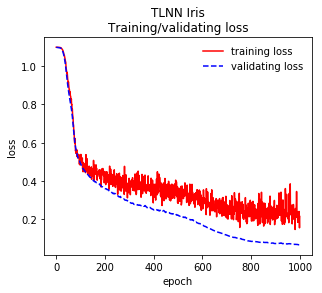

In [15]:
#----------------------------------------
# Summarize history for loss.

plt.figure('TLNN Iris loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('TLNN Iris' + '\n' + 'Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)
plt.show()


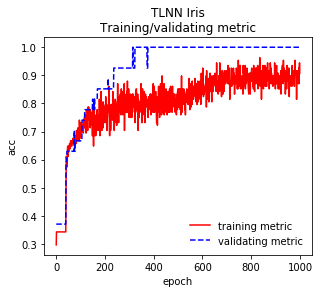

In [16]:
#----------------------------------------
# Summarize history for metric.

plt.figure('TLNN Iris metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('TLNN Iris' + '\n' + 'Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
plt.show()
